In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import tqdm
import os
from copy import deepcopy
import xgboost as xgb

## 1. EDA

In [3]:
def select(startdate, enddate, pathsplit="HQ/tick_159919/splitdata.h5"):
    with pd.HDFStore(pathsplit, 'r') as split:
        keys = list(split.keys())
        keys = [i for i in keys if i>=pathsplit[2:14]+"_"+str(startdate) and i<=pathsplit[2:14] + "_" + str(enddate)]
        df = pd.DataFrame()
        for i in range(len(keys)):
            df = df.append(split[keys[i]])
    return df
df = select(20160104,20160601)

In [196]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 642783 entries, 2016-01-04 09:25:00.860000 to 2016-12-30 14:57:00
Data columns (total 54 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   offer_price1              642783 non-null  float64
 1   offer_price2              642783 non-null  float64
 2   offer_price3              642783 non-null  float64
 3   offer_price4              642783 non-null  float64
 4   offer_price5              642783 non-null  float64
 5   offer_price6              642783 non-null  float64
 6   offer_price7              642783 non-null  float64
 7   offer_price8              642783 non-null  float64
 8   offer_price9              642783 non-null  float64
 9   offer_price10             642783 non-null  float64
 10  offer_volume1             642783 non-null  float64
 11  offer_volume2             642783 non-null  float64
 12  offer_volume3             642783 non-null  float64
 13  off

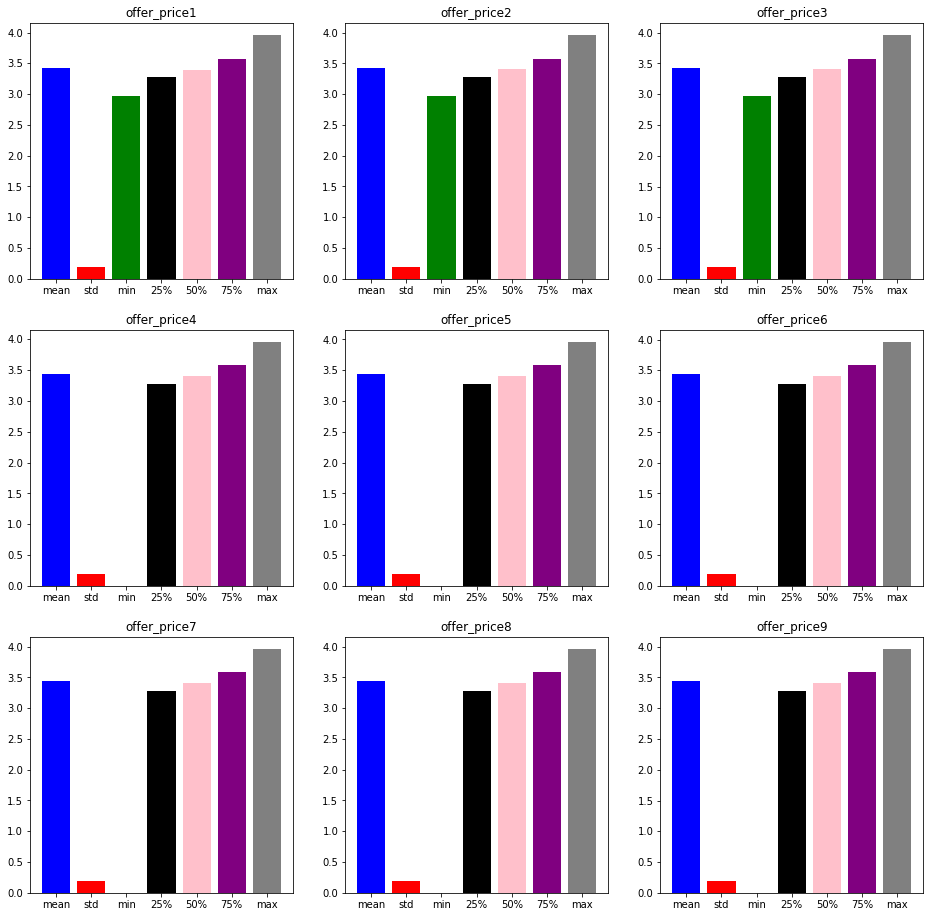

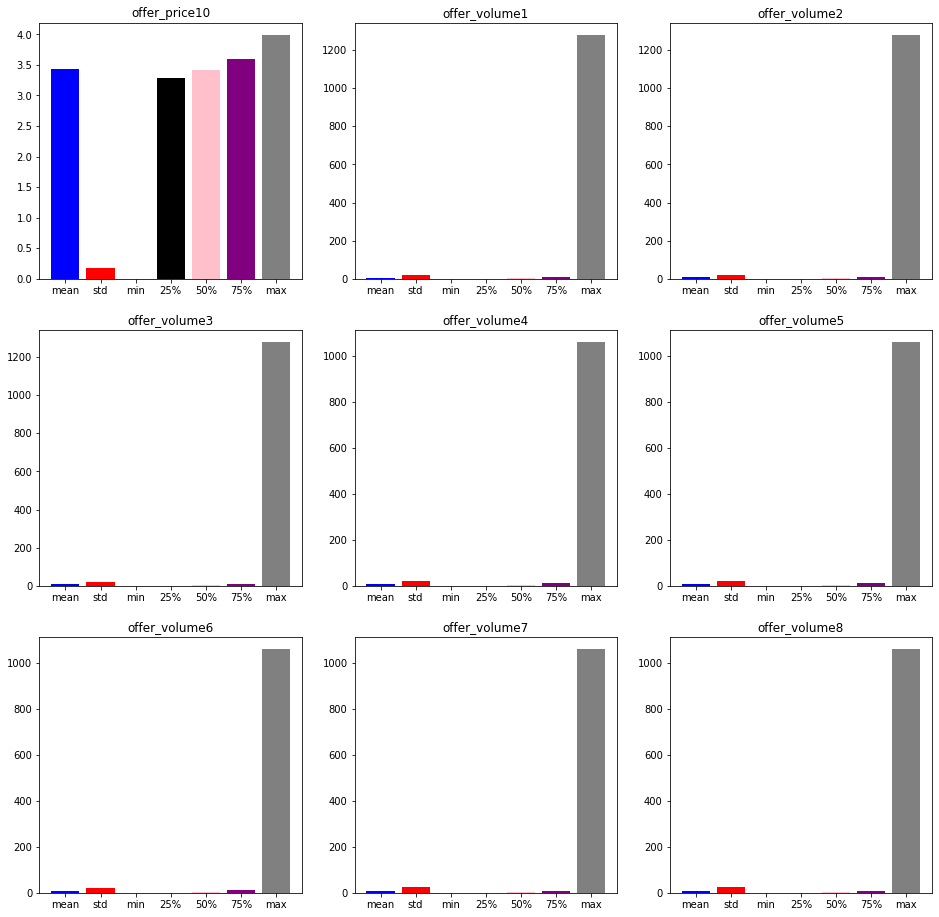

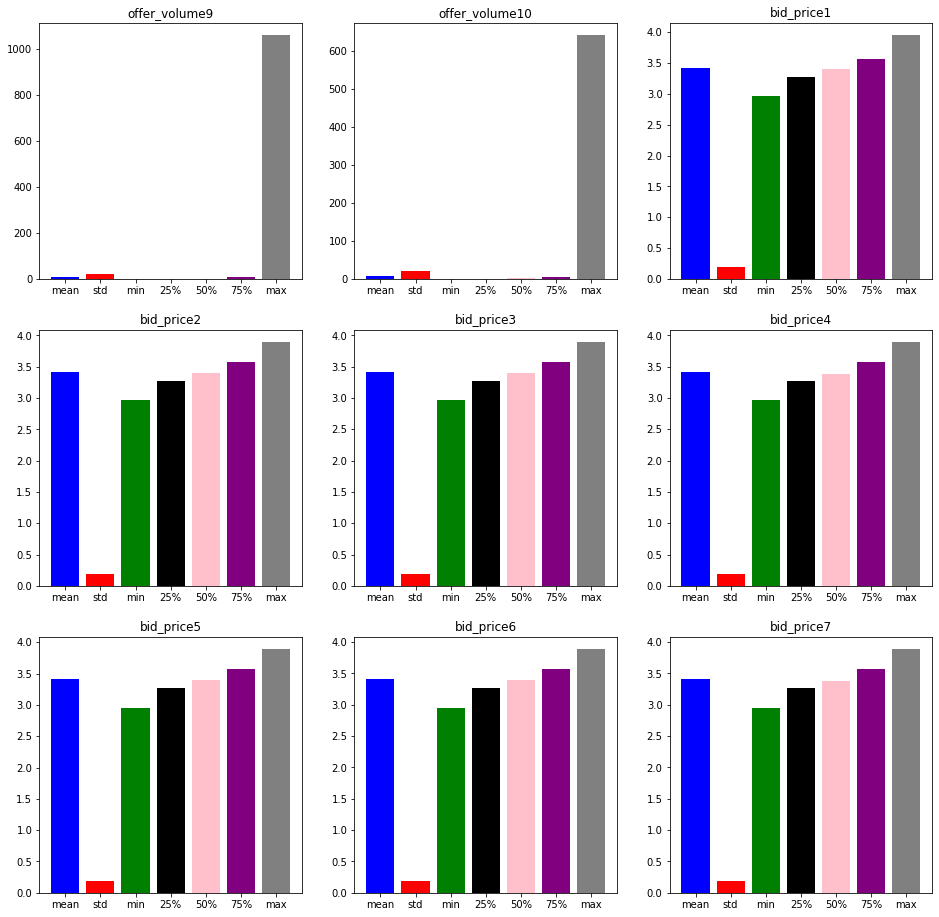

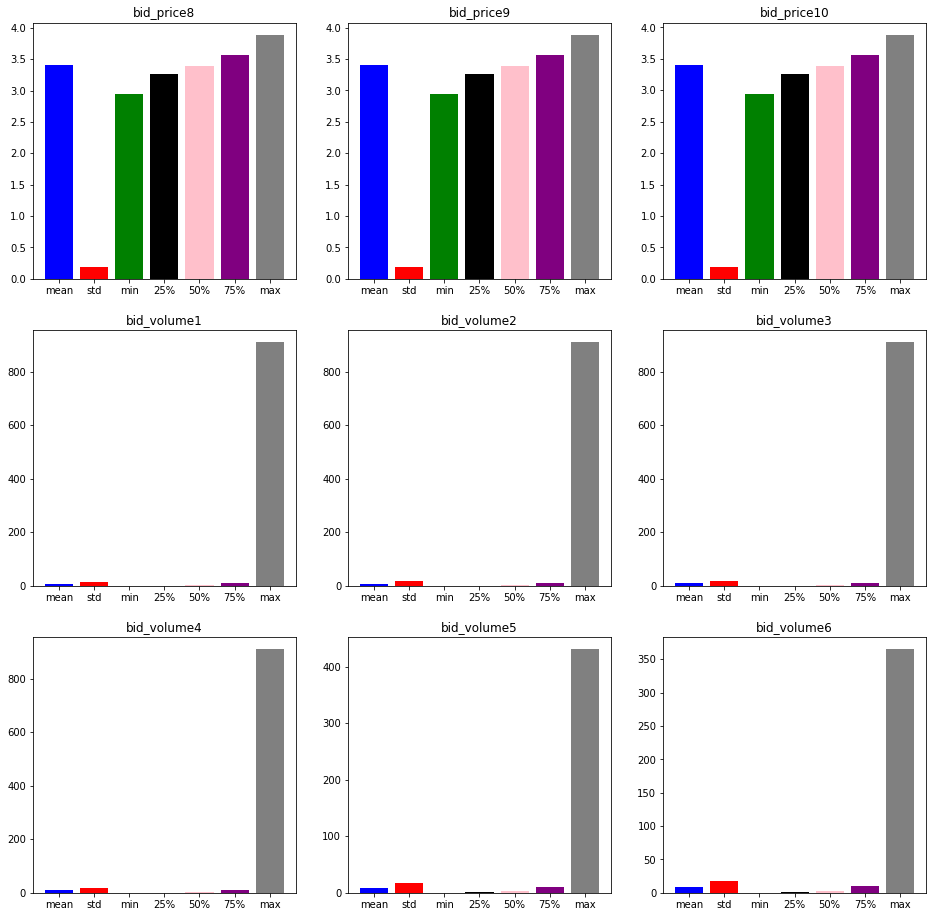

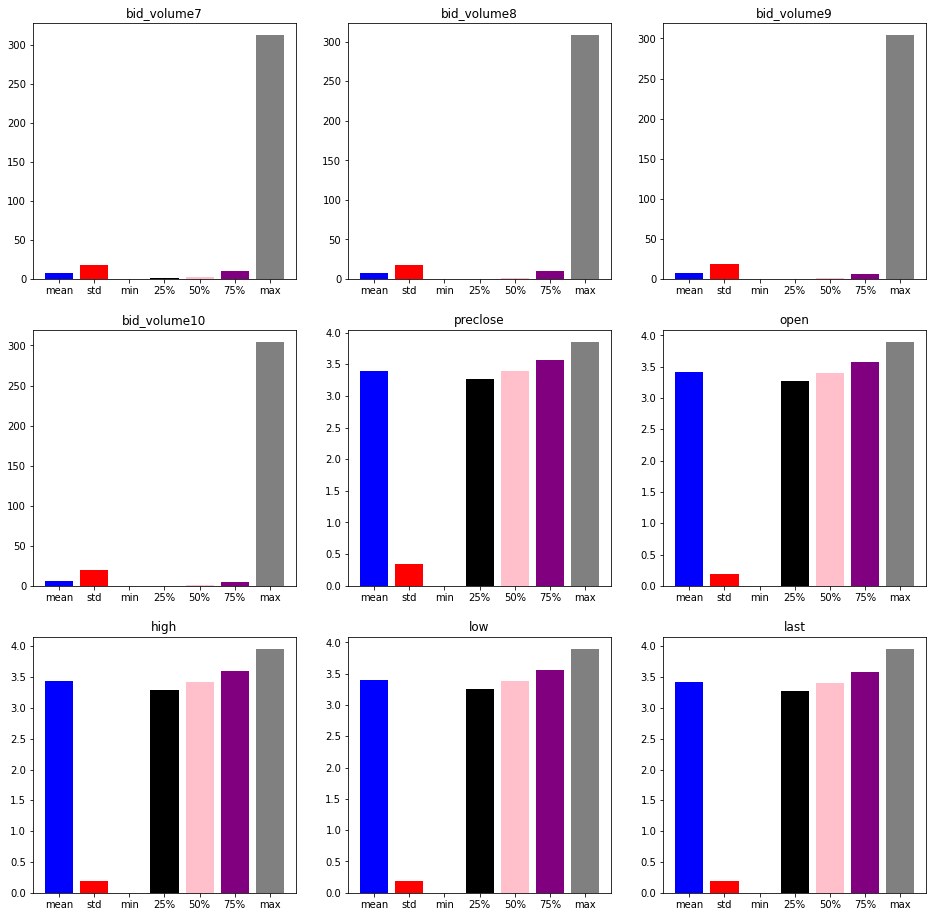

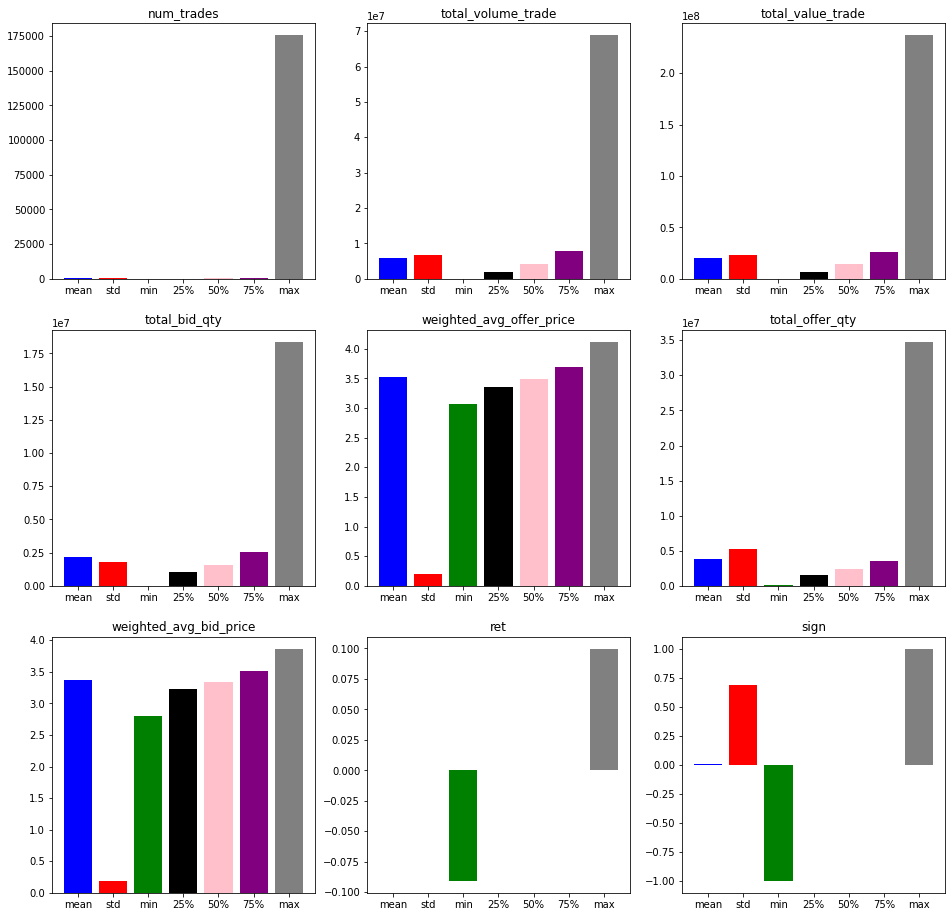

In [177]:
desc = df.describe()
index = desc.index[1:]
desc = desc.loc[index]
columns = desc.columns
colors = ['blue', 'red', 'green', 'black', 'pink', 'purple', 'gray', 'yellow']
for i in range(6):
    plt.figure(figsize=(16, 16))
    for ii in range(9):
        ax = plt.subplot(3, 3, ii + 1)
        ax.set_title(columns[i*9+ii])
        for j in range(len(index)):
            plt.bar(index[j], desc.loc[index[j], columns[i*9+ii]], color=colors[j])
    plt.savefig("picture/stat"+columns[i*9+ii])

In [198]:
df['mid'] = (df['offer_price1']+df['bid_price1'])/2

<AxesSubplot:xlabel='datetime'>

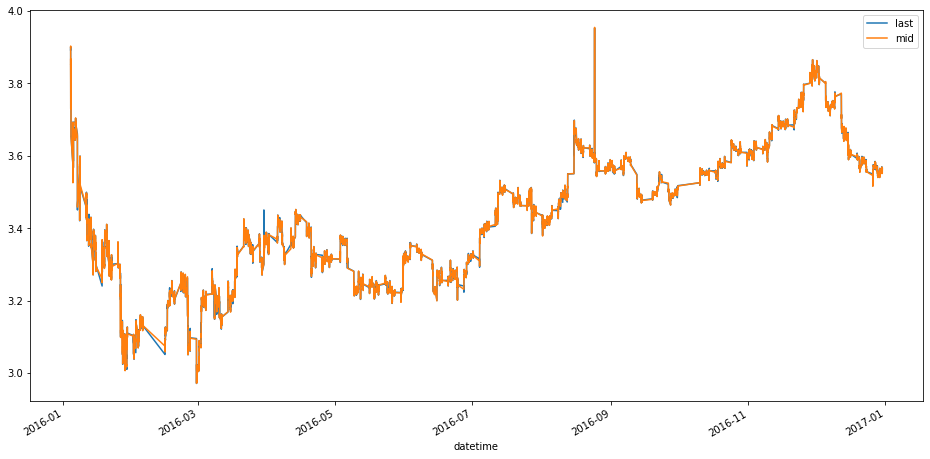

In [199]:
df.loc[df['last']!=0,['last','mid']].plot(figsize=(16,8))

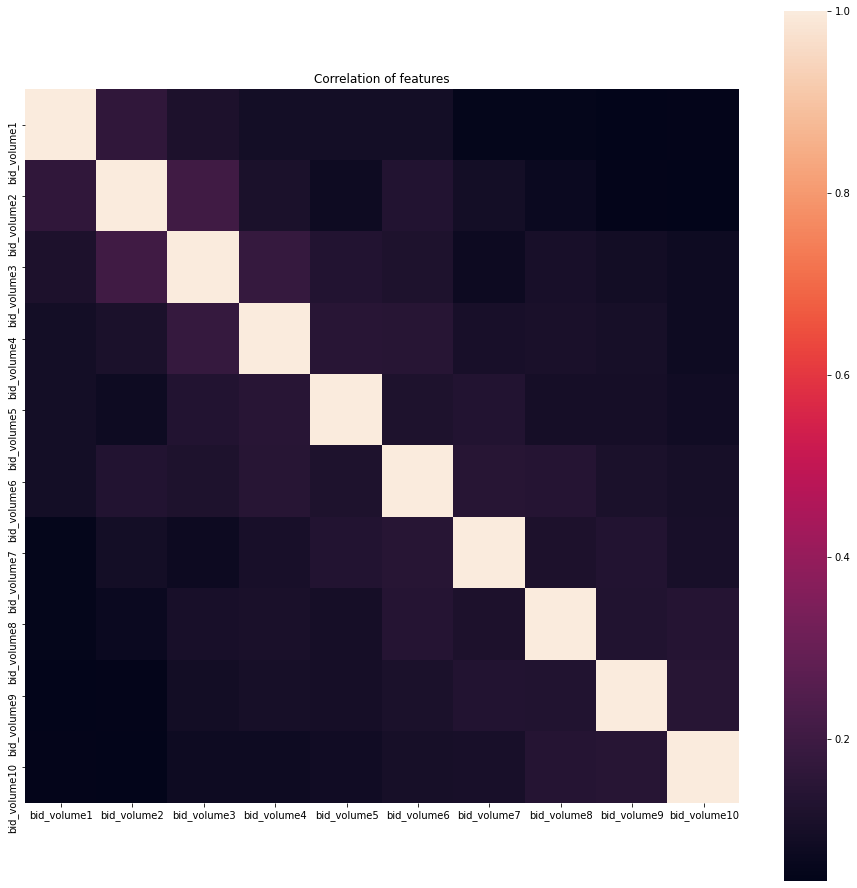

In [193]:
import seaborn as sns
import missingno as msno
import scipy.stats as st
corr = df.loc[:,['bid_volume1', 'bid_volume2', 'bid_volume3', 'bid_volume4',
                 'bid_volume5', 'bid_volume6', 'bid_volume7', 'bid_volume8',
                 'bid_volume9', 'bid_volume10']].corr()
plt.figure(figsize=(16, 16))
plt.title("Correlation of features")
sns.heatmap(corr, square=True)
plt.savefig("picture/corr_bidvolume")

In [214]:
corr = df.loc[:,['offer_volume1', 'offer_volume2',
                               'offer_volume3', 'offer_volume4', 'offer_volume5', 'offer_volume6',
                               'offer_volume7', 'offer_volume8', 'offer_volume9', 'offer_volume10']]

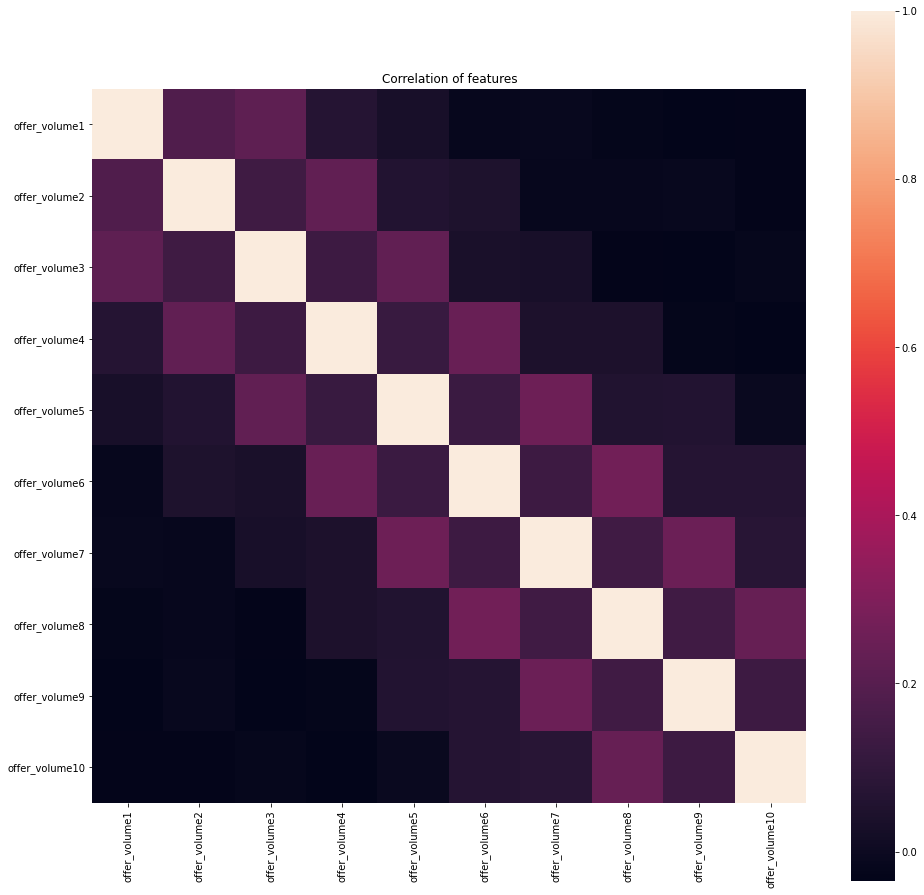

In [217]:
plt.figure(figsize=(16, 16))
plt.title("Correlation of features")
sns.heatmap(filt_df.corr(), square=True)
plt.savefig("picture/corr_offervolume_new")

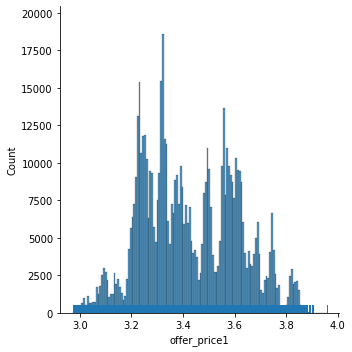

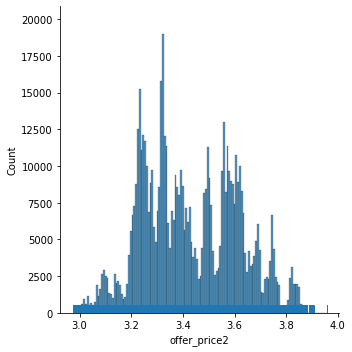

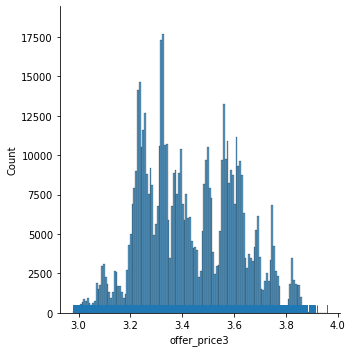

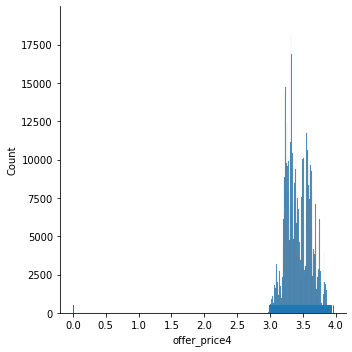

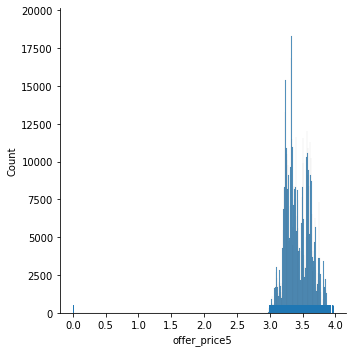

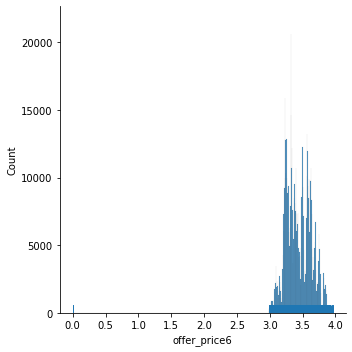

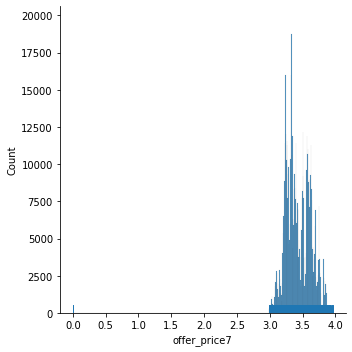

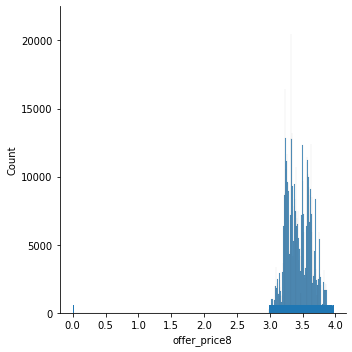

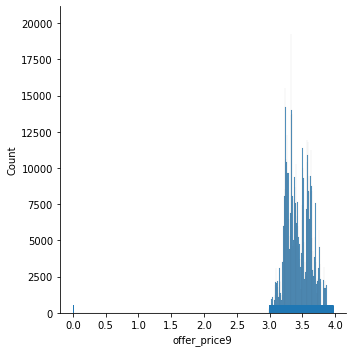

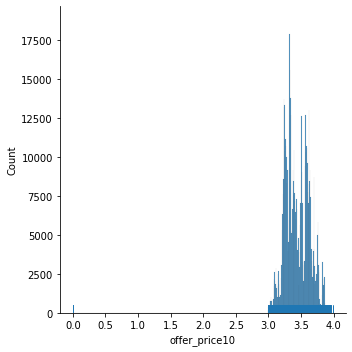

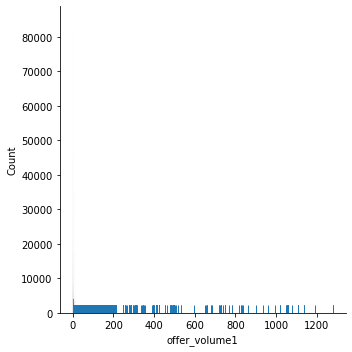

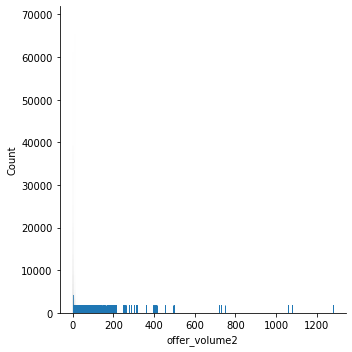

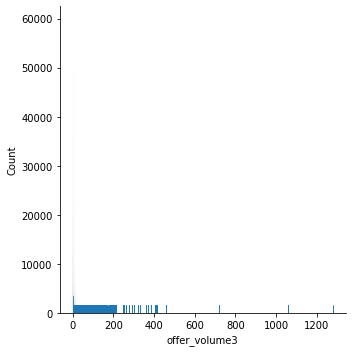

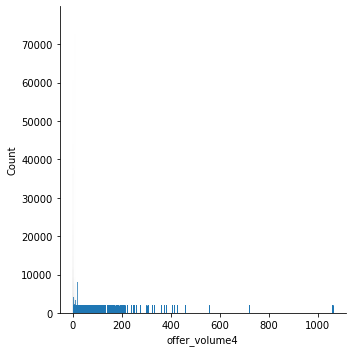

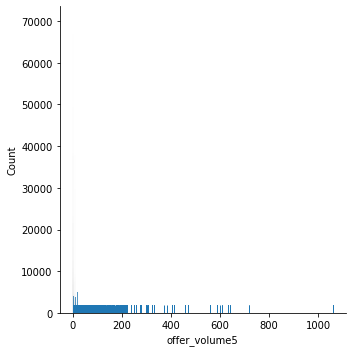

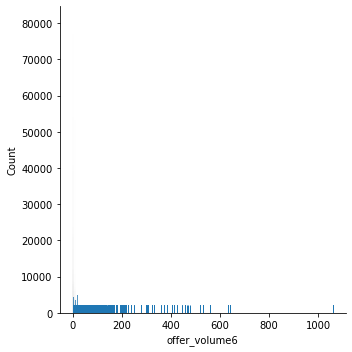

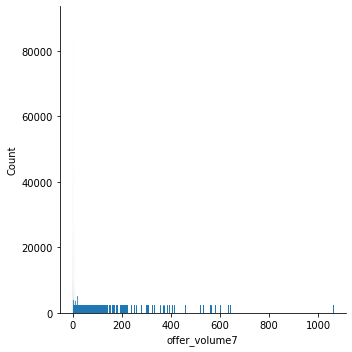

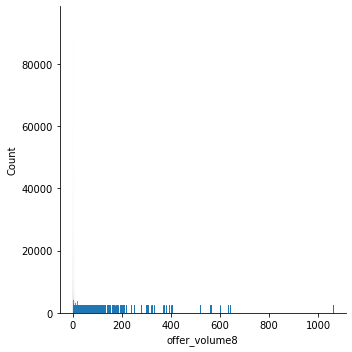

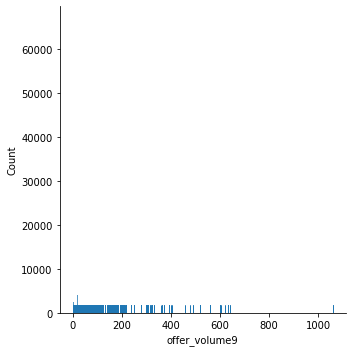

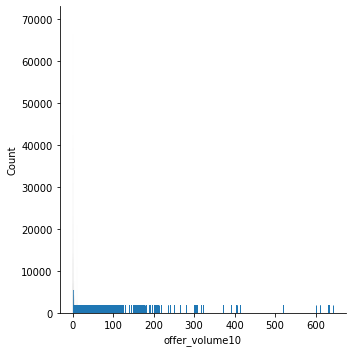

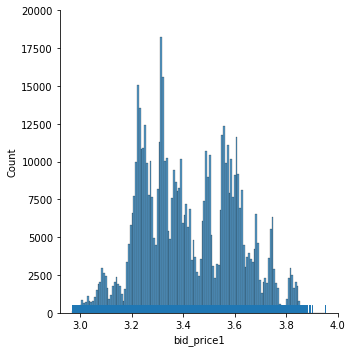

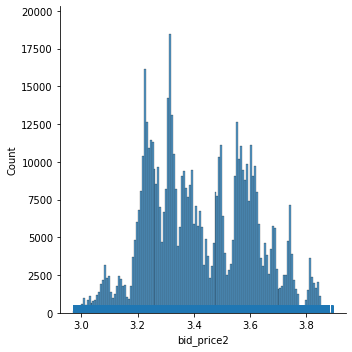

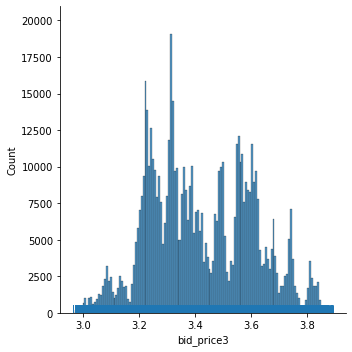

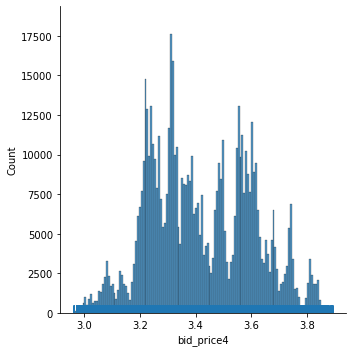

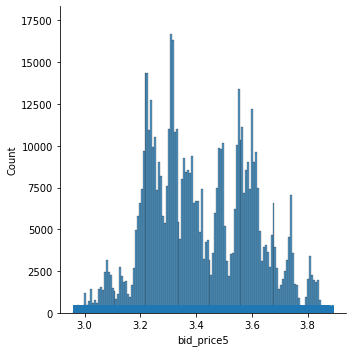

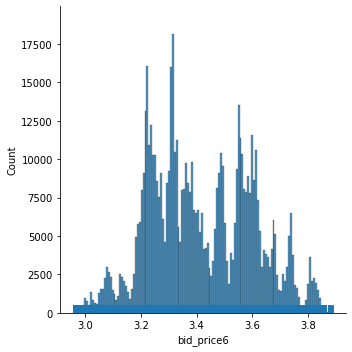

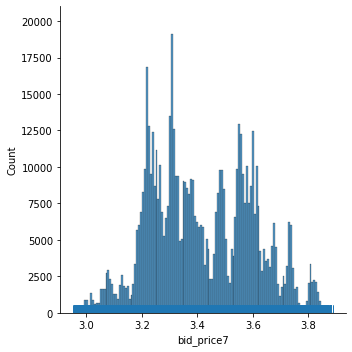

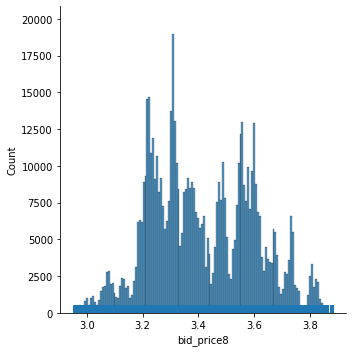

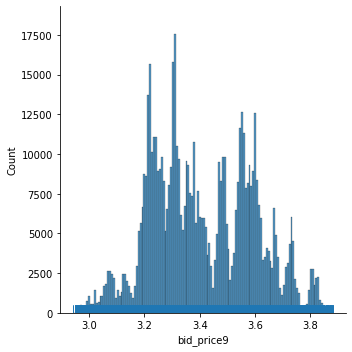

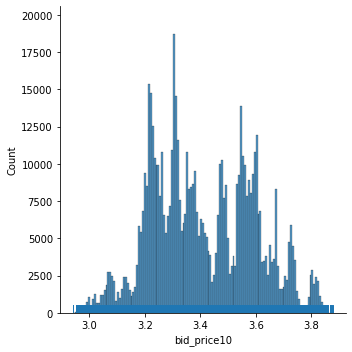

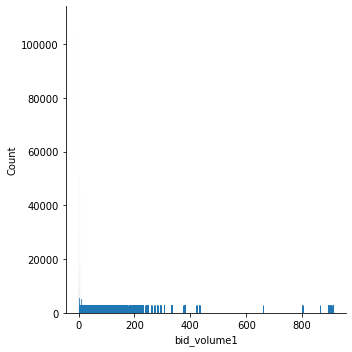

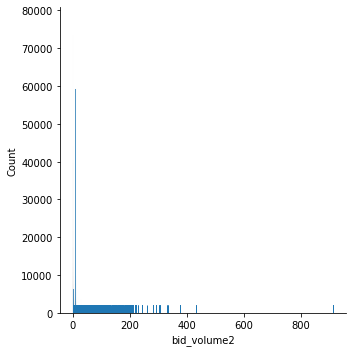

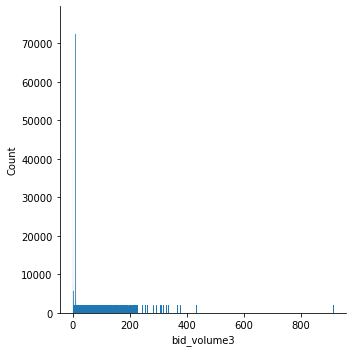

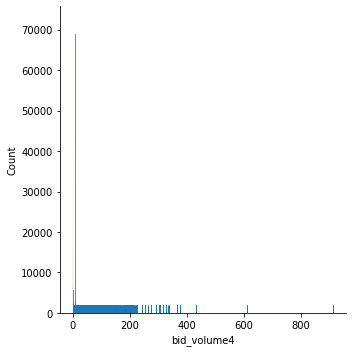

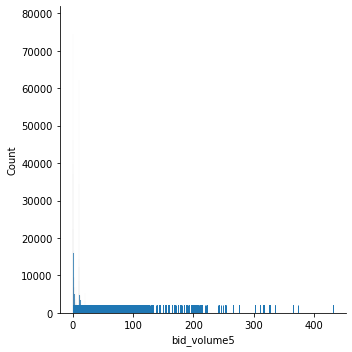

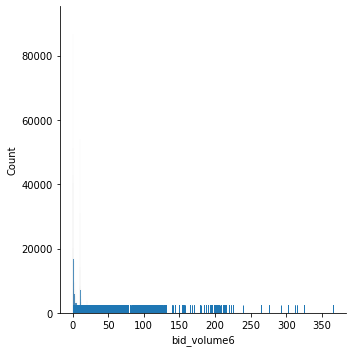

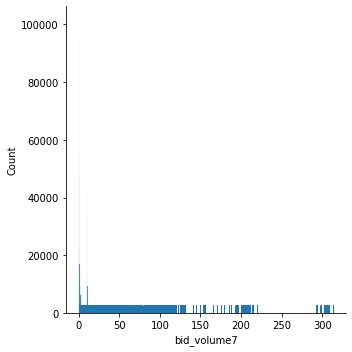

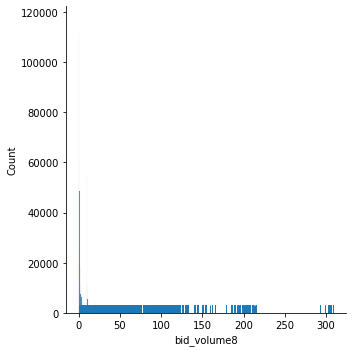

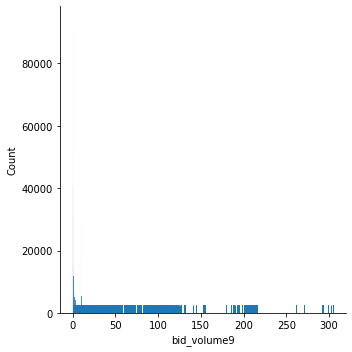

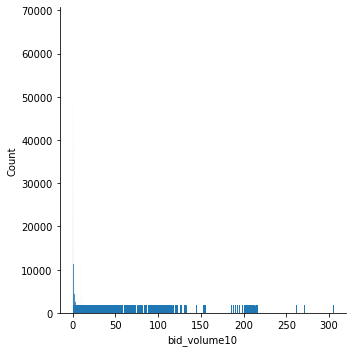

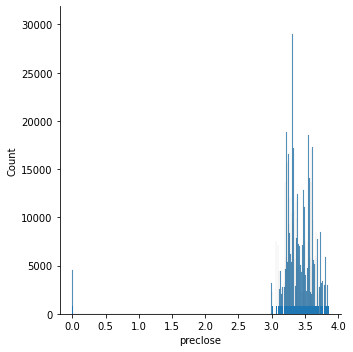

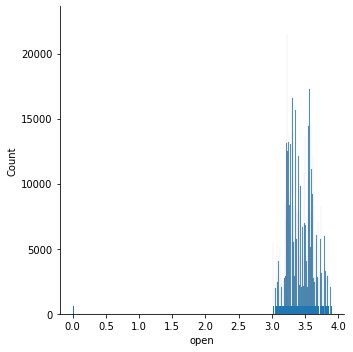

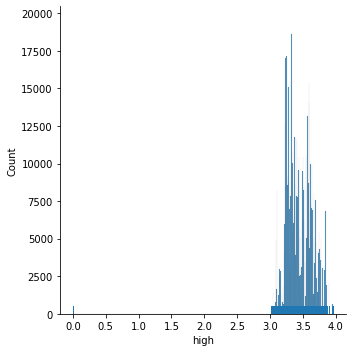

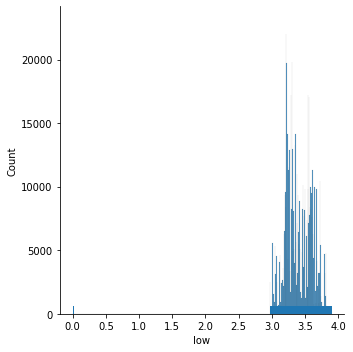

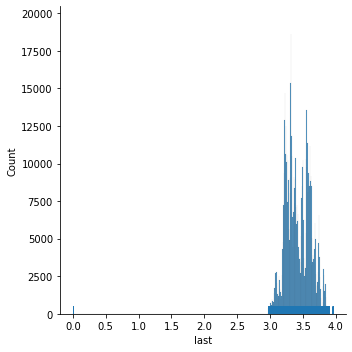

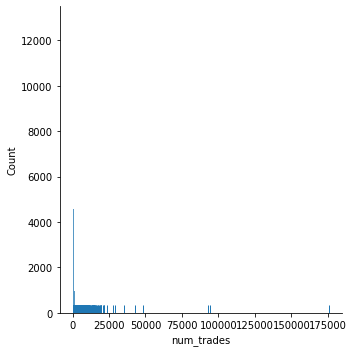

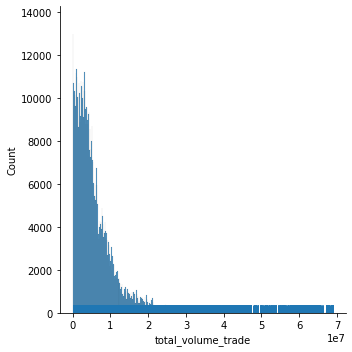

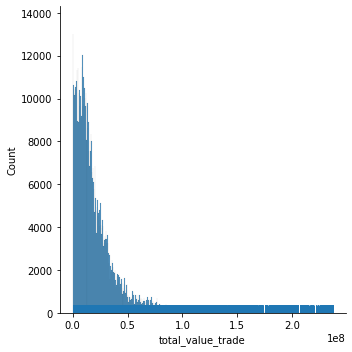

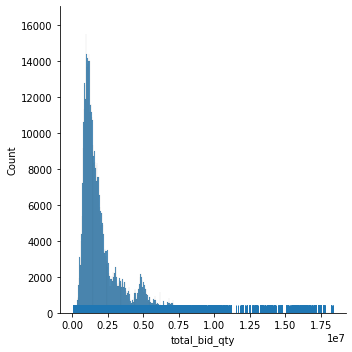

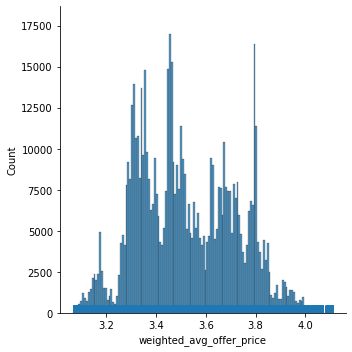

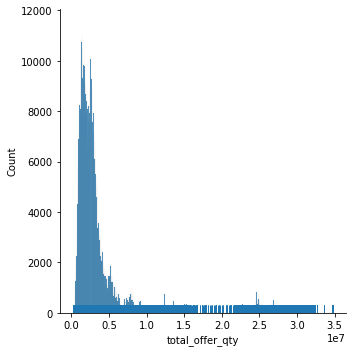

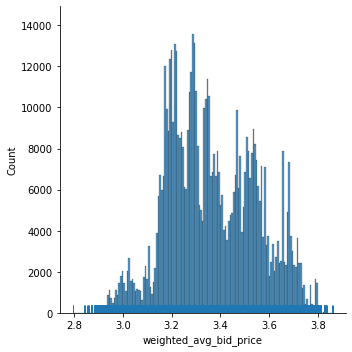

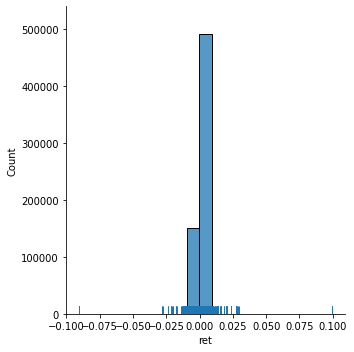

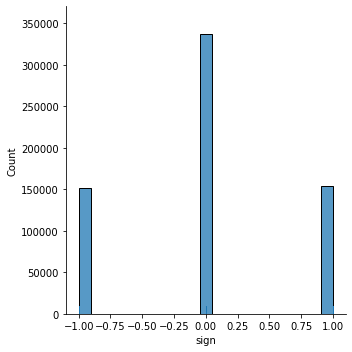

In [228]:
for i in range(df.shape[1]):
    sns.displot(df, x=df.columns[i], rug=True)
    plt.show()

In [246]:
## 特征重要性
x_train = df.iloc[:,:-2]
columns = x_train.columns
x_train = x_train.values
y_train = df.iloc[:,-1].values

In [243]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10, max_depth=None,min_samples_split=2, random_state=0)
clf.fit(x_train, y_train)
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
indices = np.argsort(importances)[::-1]# Print the feature ranking

Feature ranking:
1. feature 1 total_bid_qty (0.049574)
2. feature 2 total_offer_qty (0.049298)
3. feature 3 bid_volume1 (0.048748)
4. feature 4 offer_volume1 (0.045917)
5. feature 5 num_trades (0.039425)
6. feature 6 total_value_trade (0.035498)
7. feature 7 total_volume_trade (0.034758)
8. feature 8 bid_volume2 (0.027981)
9. feature 9 weighted_avg_offer_price (0.027077)
10. feature 10 offer_volume2 (0.026847)
11. feature 11 weighted_avg_bid_price (0.026631)
12. feature 12 bid_volume3 (0.024582)
13. feature 13 bid_volume4 (0.023824)
14. feature 14 offer_volume3 (0.023349)
15. feature 15 bid_volume5 (0.023101)
16. feature 16 bid_volume6 (0.022434)
17. feature 17 offer_volume4 (0.022183)
18. feature 18 bid_volume7 (0.020725)
19. feature 19 offer_volume5 (0.020723)
20. feature 20 bid_volume8 (0.020355)
21. feature 21 offer_volume6 (0.020051)
22. feature 22 bid_volume10 (0.019918)
23. feature 23 bid_volume9 (0.019788)
24. feature 24 offer_volume7 (0.019188)
25. feature 25 offer_volume9 (0.

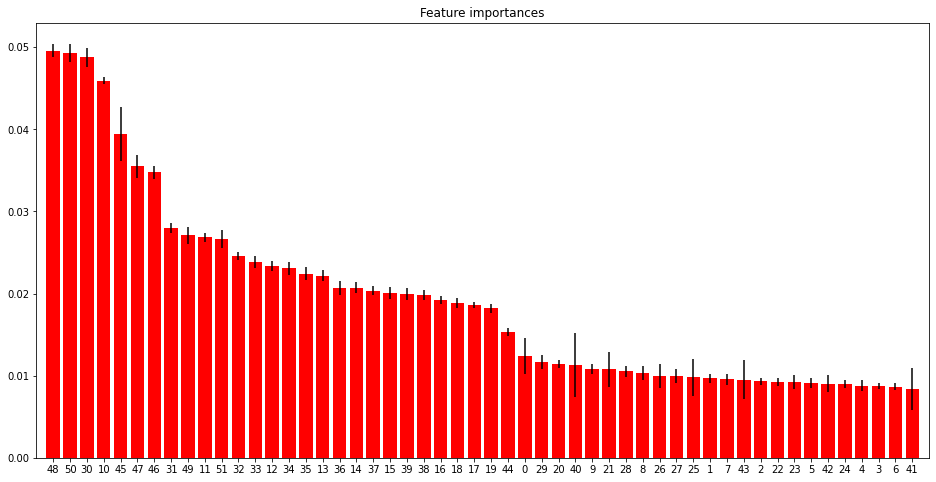

In [249]:
print("Feature ranking:")
for f in range(x_train.shape[1]):    
    print("%d. feature %d %s (%f)" % (f+1, f+1, columns[indices[f]],  importances[indices[f]]))
# Plot the feature importances of the forest
plt.figure(figsize=(16,8))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), indices)
plt.xlim([-1, x_train.shape[1]])
plt.show()

## 2. Decision tree

In [8]:
import pandas as pd
import numpy as np
def select(startdate, enddate, pathsplit="HQ/tick_159919/splitdata.h5"):
    with pd.HDFStore(pathsplit, 'r') as split:
        keys = list(split.keys())
        keys = [i for i in keys if i>=pathsplit[2:14]+"_"+str(startdate) and i<=pathsplit[2:14] + "_" + str(enddate)]
        df = pd.DataFrame()
        for i in range(len(keys)):
            df = df.append(split[keys[i]])
    return df
df = select(20160104,20160601)
x_train = df.iloc[:,:-2]
columns = x_train.columns
x_train = x_train.values
y_train = df.iloc[:,-1].values

In [86]:
df.loc[:,['bid_volume1','offer_volume1']].describe()

,bid_volume1,offer_volume1
count,279558.000000,279558.000000
mean,4.935679,5.366560
std,13.957018,20.485556
min,0.000100,0.000100
25%,0.370000,0.470000
50%,1.230000,1.442600
75%,5.090000,5.440300
max,909.946200,1277.651600


In [103]:
import random
def resample(x_train, y_train):
    a, b, c = (np.sum(y_train==-1),np.sum(y_train==0),np.sum(y_train==1))
    keeps = a+c
    idx = np.where(y_train==0)[0]
    idx = random.sample(list(idx), keeps)
    idx = idx + list(np.where(y_train==-1)[0]) + list(np.where(y_train==1)[0])
    x_train = x_train[idx]
    y_train = y_train[idx]
    return x_train, y_train
x_train, y_train = resample(x_train, y_train)

In [132]:
(np.sum(y_train==-1),np.sum(y_train==0),np.sum(y_train==1))

(41238, 196730, 41590)

In [11]:
## decision tree
from sklearn import tree
params = {'splitter':'random',
          'max_depth':4,
          'min_samples_split':20,
          'min_samples_leaf':10,
          'class_weight':'balanced',
          'random_state':0
         }
clf = tree.DecisionTreeClassifier(**params)
clf = clf.fit(x_train, y_train)

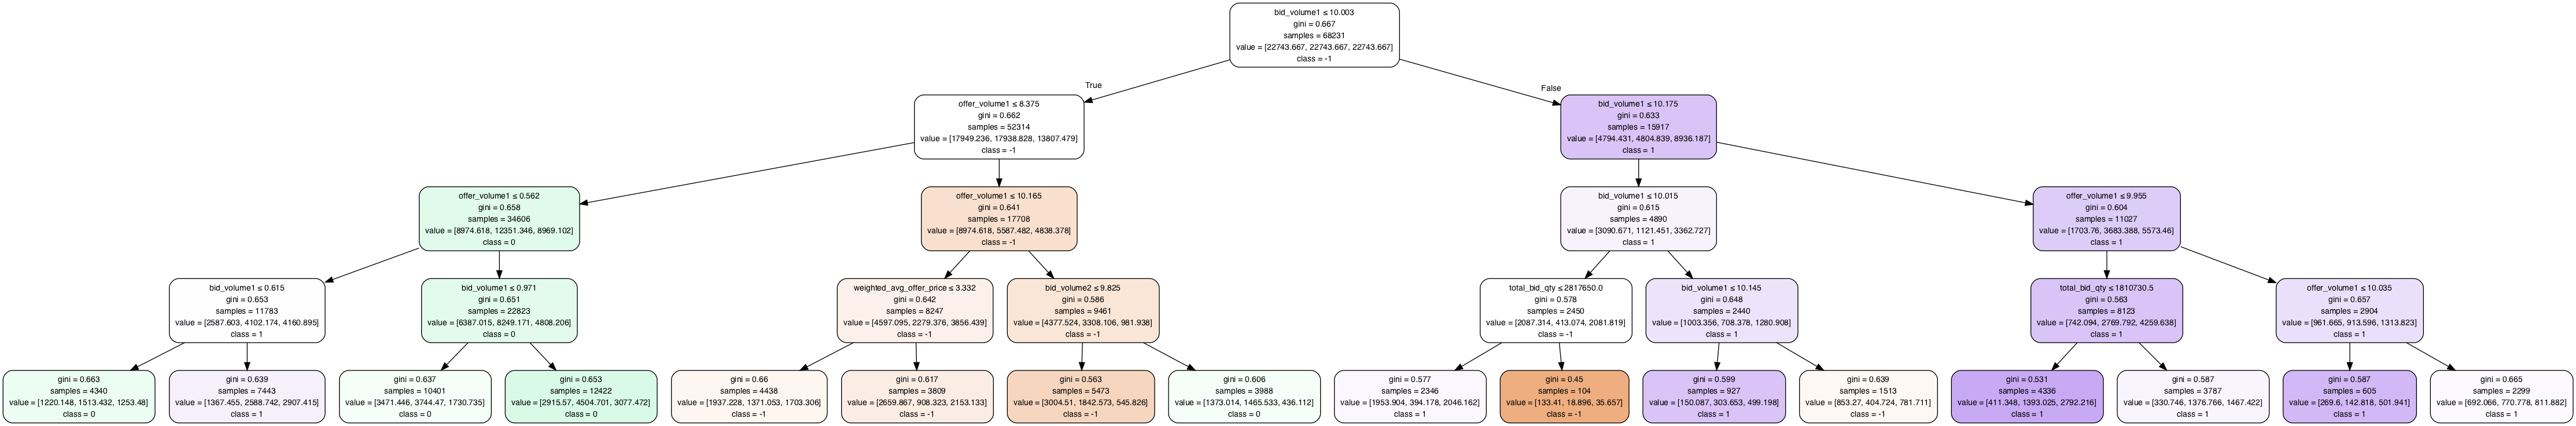

In [125]:
from IPython.display import Image
import pydotplus
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=columns,  
                         class_names=['-1','0','1'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_pdf("result/depth5.png")
Image(graph.create_png())

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
y_predprob = clf.predict_proba(x_train)
y_pred = clf.predict(x_train)
print("accuracy_score Score (Train): %f" % accuracy_score(y_train, y_pred))
print("AUC Score (Train): %f" % roc_auc_score(y_train, y_predprob,multi_class='ovr'))
print(confusion_matrix(y_train, y_pred))

accuracy_score Score (Train): 0.555073
AUC Score (Train): 0.546976
[[  5791  28030   7417]
 [ 18955 136999  40776]
 [  5157  24048  12385]]


Feature ranking:
1. feature 1 bid_volume1 (0.416011)
2. feature 2 offer_price1 (0.279640)
3. feature 3 total_volume_trade (0.121885)
4. feature 4 preclose (0.118189)
5. feature 5 offer_price6 (0.015502)
6. feature 6 offer_price3 (0.015148)
7. feature 7 bid_price4 (0.013358)
8. feature 8 bid_price8 (0.009193)
9. feature 9 num_trades (0.006621)
10. feature 10 total_bid_qty (0.004453)
11. feature 11 offer_price4 (0.000000)
12. feature 12 offer_volume5 (0.000000)
13. feature 13 bid_price1 (0.000000)
14. feature 14 offer_volume10 (0.000000)
15. feature 15 offer_volume9 (0.000000)
16. feature 16 offer_volume8 (0.000000)
17. feature 17 offer_volume7 (0.000000)
18. feature 18 offer_price2 (0.000000)
19. feature 19 offer_volume6 (0.000000)
20. feature 20 offer_volume4 (0.000000)
21. feature 21 offer_price5 (0.000000)
22. feature 22 offer_volume3 (0.000000)
23. feature 23 offer_volume2 (0.000000)
24. feature 24 offer_volume1 (0.000000)
25. feature 25 bid_price2 (0.000000)
26. feature 26 offer_pr

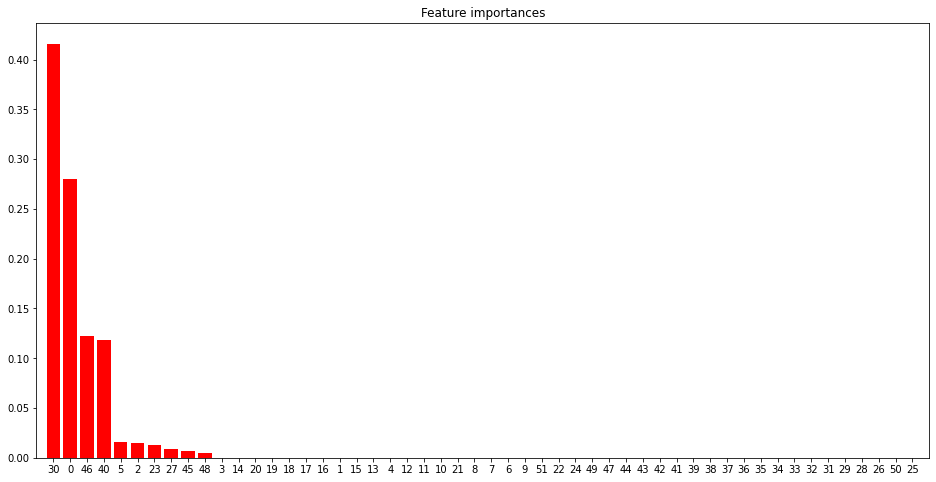

In [138]:
clf = tree.DecisionTreeClassifier(**params)
clf = clf.fit(x_train, y_train)
importances = clf.feature_importances_
#std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
indices = np.argsort(importances)[::-1]# Print the feature ranking
print("Feature ranking:")
for f in range(x_train.shape[1]):    
    print("%d. feature %d %s (%f)" % (f+1, f+1, columns[indices[f]],  importances[indices[f]]))
# Plot the feature importances of the forest
plt.figure(figsize=(16,8))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(x_train.shape[1]), indices)
plt.xlim([-1, x_train.shape[1]])
plt.show()

### feature engineering

In [4]:
import pandas as pd
import numpy as np
def select(startdate, enddate, pathsplit="HQ/tick_159919/splitdata.h5"):
    with pd.HDFStore(pathsplit, 'r') as split:
        keys = list(split.keys())
        keys = [i for i in keys if i>=pathsplit[2:14]+"_"+str(startdate) and i<=pathsplit[2:14] + "_" + str(enddate)]
        df = pd.DataFrame()
        for i in range(len(keys)):
            df = df.append(split[keys[i]])
    return df
df = select(20160104,20160601)
x_train = deepcopy(df.iloc[:,:-2])
columns = x_train.columns
x_train = x_train.values
y_train = deepcopy(df.iloc[:,-1]).values

In [30]:
from sklearn import tree
## classification tree
params = {'splitter':'random',
          'max_depth':4,
          'min_samples_split':20,
          'min_samples_leaf':10,
          'class_weight':'balanced',
          'random_state':0
         }
clf = tree.DecisionTreeClassifier(**params)
clf = clf.fit(x_train, y_train)
y_predprob = clf.predict_proba(x_train)
y_pred = clf.predict(x_train)
print("accuracy_score Score (Train): %f" % accuracy_score(y_train, y_pred))
print("AUC Score (Train): %f" % roc_auc_score(y_train, y_predprob,multi_class='ovr'))
print(confusion_matrix(y_train, y_pred))

accuracy_score Score (Train): 0.555073
AUC Score (Train): 0.546976
[[  5791  28030   7417]
 [ 18955 136999  40776]
 [  5157  24048  12385]]


In [104]:
# regression tree
x_train = deepcopy(df.iloc[:,:-2])
x_train = x_train.values
y_train = deepcopy(df.iloc[:,-2]).values
params = {'splitter':'random',
          'max_depth':4,
          'min_samples_split':20,
          'min_samples_leaf':10,
          'random_state':0
         }
clf = tree.DecisionTreeRegressor(**params)
clf = clf.fit(x_train, y_train)
y_pred = clf.predict(x_train)

In [105]:
def category(y, pos1=0, pos2=0):
    print(pos1,pos2)
    idx1 = np.where(y>pos2)
    idx2 = np.where((y_pred<=pos2) & (y_pred>=pos1))
    idx3 = np.where(y<pos1)
    y[idx1] = 1
    y[idx2] = 0
    y[idx3] = -1
    return y
y_train = category(y_train)
y_pred = category(y_pred,-1.5105443869637652e-05,-3.637465286726236e-06)
print("accuracy_score Score (Train): %f" % accuracy_score(y_train, y_pred))
print(confusion_matrix(y_train, y_pred))

0 0
-1.5105443869637652e-05 -3.637465286726236e-06
accuracy_score Score (Train): 0.601936
[[   571  33436   7231]
 [   591 155449  40690]
 [   243  29091  12256]]


In [18]:
## feature standardlize
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.decomposition import KernelPCA, SparsePCA
from sklearn import tree

x_train = deepcopy(df.iloc[:,:-2])
x_train = x_train.values
y_train = deepcopy(df.iloc[:,-1]).values

params = {'splitter':'random',
          'max_depth':4,
          'min_samples_split':20,
          'min_samples_leaf':10,
          'class_weight':'balanced',
          'random_state':0
         }

# pipe = Pipeline([('robustscaler', RobustScaler()), 
#                  ('standardscaler', StandardScaler()), 
#                  ('pca', KernelPCA(n_components=7, kernel='linear')),
#                  ('clf', clf)
#                 ])
# pipe.fit(x_train, y_train)

robustscaler = RobustScaler().fit(x_train)
x_train = robustscaler.transform(x_train)
standardscaler = StandardScaler().fit(x_train)
x_train = standardscaler.transform(x_train)
minmaxscaler = MinMaxScaler().fit(x_train)
x_train = minmaxscaler.transform(x_train)

In [19]:
pca = SparsePCA(n_components=7, random_state=15).fit(x_train)
x_train = pca.transform(x_train)

clf = tree.DecisionTreeClassifier(**params)
clf.fit(x_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                       min_samples_leaf=10, min_samples_split=20,
                       random_state=0, splitter='random')

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
y_predprob = clf.predict_proba(x_train)
y_pred = clf.predict(x_train)
print("accuracy_score Score (Train): %f" % accuracy_score(y_train, y_pred))
print("AUC Score (Train): %f" % roc_auc_score(y_train, y_predprob,multi_class='ovr'))
print(confusion_matrix(y_train, y_pred))

accuracy_score Score (Train): 0.478462
AUC Score (Train): 0.537372
[[ 11940  21269   8029]
 [ 46290 113026  37414]
 [ 11348  21450   8792]]


In [21]:
# regression tree
x_train = deepcopy(df.iloc[:,:-2])
x_train = x_train.values
y_train = deepcopy(df.iloc[:,-2]).values
robustscaler = RobustScaler().fit(x_train)
x_train = robustscaler.transform(x_train)
standardscaler = StandardScaler().fit(x_train)
x_train = standardscaler.transform(x_train)
minmaxscaler = MinMaxScaler().fit(x_train)
x_train = minmaxscaler.transform(x_train)
pca = SparsePCA(n_components=7, random_state=15).fit(x_train)
x_train = pca.transform(x_train)
params = {'splitter':'random',
          'max_depth':4,
          'min_samples_split':20,
          'min_samples_leaf':10,
          'random_state':0
         }
clf = tree.DecisionTreeRegressor(**params)
clf = clf.fit(x_train, y_train)
y_pred = clf.predict(x_train)

In [22]:
def category(y, pos1=0, pos2=0):
    print(pos1,pos2)
    idx1 = np.where(y>pos2)
    idx2 = np.where((y_pred<=pos2) & (y_pred>=pos1))
    idx3 = np.where(y<pos1)
    y[idx1] = 1
    y[idx2] = 0
    y[idx3] = -1
    return y
y_train = category(y_train)
y_pred = category(y_pred,np.quantile(y_pred,0.25),np.quantile(y_pred,0.75))
print("accuracy_score Score (Train): %f" % accuracy_score(y_train, y_pred))
print(confusion_matrix(y_train, y_pred))

0 0
1.7682162168102787e-06 1.7682162168102787e-06
accuracy_score Score (Train): 0.694461
[[  1334  39380    524]
 [  2898 192223   1609]
 [  1009  39996    585]]


In [23]:
## feature ranking multiple trees

In [39]:
x_train = deepcopy(df.iloc[:,:-2])
x_train = x_train.values
y_train = deepcopy(df.iloc[:,-1]).values
clf = tree.DecisionTreeClassifier(**params)
clf.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=10, min_samples_split=20,
                       random_state=0, splitter='random')

Feature ranking:
1. feature 30 bid_volume1 (0.416011)
2. feature 0 offer_price1 (0.279640)
3. feature 46 total_volume_trade (0.121885)
4. feature 40 preclose (0.118189)
5. feature 5 offer_price6 (0.015502)
6. feature 2 offer_price3 (0.015148)
7. feature 23 bid_price4 (0.013358)
8. feature 27 bid_price8 (0.009193)
9. feature 45 num_trades (0.006621)
10. feature 48 total_bid_qty (0.004453)
11. feature 3 offer_price4 (0.000000)
12. feature 14 offer_volume5 (0.000000)
13. feature 20 bid_price1 (0.000000)
14. feature 19 offer_volume10 (0.000000)
15. feature 18 offer_volume9 (0.000000)
16. feature 17 offer_volume8 (0.000000)
17. feature 16 offer_volume7 (0.000000)
18. feature 1 offer_price2 (0.000000)
19. feature 15 offer_volume6 (0.000000)
20. feature 13 offer_volume4 (0.000000)
21. feature 4 offer_price5 (0.000000)
22. feature 12 offer_volume3 (0.000000)
23. feature 11 offer_volume2 (0.000000)
24. feature 10 offer_volume1 (0.000000)
25. feature 21 bid_price2 (0.000000)
26. feature 8 offer_

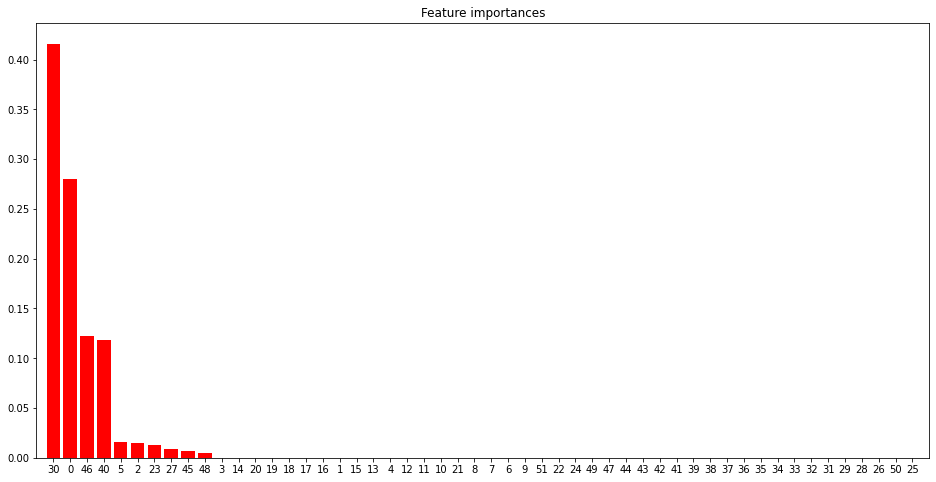

In [40]:
importances = clf.feature_importances_
#std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
indices = np.argsort(importances)[::-1]# Print the feature ranking
print("Feature ranking:")
sel = []
sel_name = []
for f in range(x_train.shape[1]):    
    print("%d. feature %d %s (%f)" % (f+1, indices[f], columns[indices[f]],  importances[indices[f]]))
    sel.append(indices[f])
    sel_name.append(columns[indices[f]])
# Plot the feature importances of the forest
plt.figure(figsize=(16,8))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(x_train.shape[1]), indices)
plt.xlim([-1, x_train.shape[1]])
plt.show()

In [41]:
sel1 = sel[:5]
sel_name1 = sel_name[:5]
sel = sel[5:]
x_train = x_train[:,sel]
clf = tree.DecisionTreeClassifier(**params)
clf.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=10, min_samples_split=20,
                       random_state=0, splitter='random')

Feature ranking:
1. feature 23 bid_price4 (0.342913)
2. feature 0 offer_price1 (0.172127)
3. feature 32 bid_volume3 (0.151772)
4. feature 5 offer_price6 (0.119802)
5. feature 18 offer_volume9 (0.054292)
6. feature 4 offer_price5 (0.051140)
7. feature 44 last (0.046707)
8. feature 42 high (0.023486)
9. feature 6 offer_price7 (0.016894)
10. feature 28 bid_price9 (0.012734)
11. feature 29 bid_price10 (0.008131)
12. feature 17 offer_volume8 (0.000000)
13. feature 16 offer_volume7 (0.000000)
14. feature 15 offer_volume6 (0.000000)
15. feature 14 offer_volume5 (0.000000)
16. feature 13 offer_volume4 (0.000000)
17. feature 12 offer_volume3 (0.000000)
18. feature 1 offer_price2 (0.000000)
19. feature 11 offer_volume2 (0.000000)
20. feature 2 offer_price3 (0.000000)
21. feature 19 offer_volume10 (0.000000)
22. feature 9 offer_price10 (0.000000)
23. feature 8 offer_price9 (0.000000)
24. feature 7 offer_price8 (0.000000)
25. feature 3 offer_price4 (0.000000)
26. feature 10 offer_volume1 (0.000000

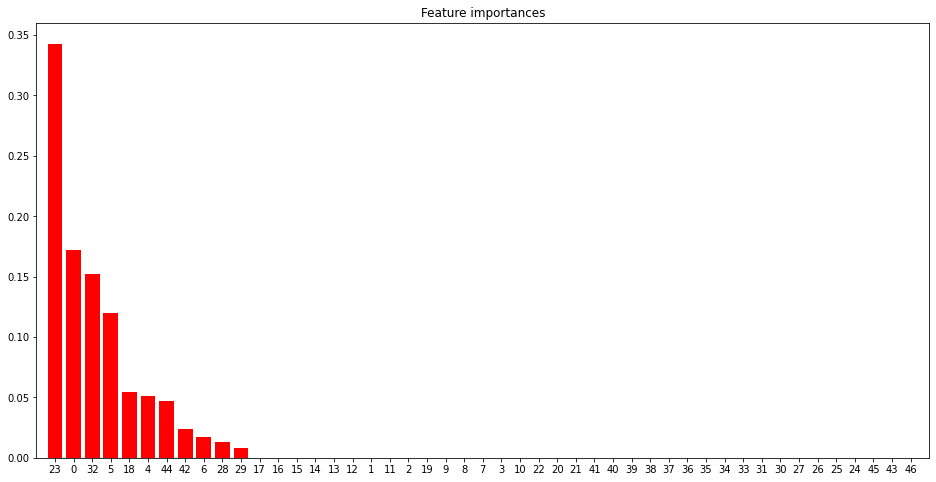

In [42]:
importances = clf.feature_importances_
#std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
indices = np.argsort(importances)[::-1]# Print the feature ranking
print("Feature ranking:")
sel = []
sel_name = []
for f in range(x_train.shape[1]):    
    print("%d. feature %d %s (%f)" % (f+1, indices[f], columns[indices[f]],  importances[indices[f]]))
    sel.append(indices[f])
    sel_name.append(columns[indices[f]])
# Plot the feature importances of the forest
plt.figure(figsize=(16,8))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(x_train.shape[1]), indices)
plt.xlim([-1, x_train.shape[1]])
plt.show()

In [44]:
sel2 = sel[:5]
sel_name2 = sel_name[:5]
sel = sel[5:]
x_train = x_train[:,sel]
clf = tree.DecisionTreeClassifier(**params)
clf.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=10, min_samples_split=20,
                       random_state=0, splitter='random')

Feature ranking:
1. feature 12 offer_volume3 (0.283905)
2. feature 39 bid_volume10 (0.267628)
3. feature 4 offer_price5 (0.106450)
4. feature 33 bid_volume4 (0.077436)
5. feature 8 offer_price9 (0.049058)
6. feature 22 bid_price3 (0.047349)
7. feature 21 bid_price2 (0.045896)
8. feature 2 offer_price3 (0.043514)
9. feature 19 offer_volume10 (0.040449)
10. feature 5 offer_price6 (0.013816)
11. feature 14 offer_volume5 (0.011393)
12. feature 0 offer_price1 (0.007101)
13. feature 35 bid_volume6 (0.006006)
14. feature 17 offer_volume8 (0.000000)
15. feature 9 offer_price10 (0.000000)
16. feature 10 offer_volume1 (0.000000)
17. feature 11 offer_volume2 (0.000000)
18. feature 7 offer_price8 (0.000000)
19. feature 13 offer_volume4 (0.000000)
20. feature 6 offer_price7 (0.000000)
21. feature 3 offer_price4 (0.000000)
22. feature 15 offer_volume6 (0.000000)
23. feature 1 offer_price2 (0.000000)
24. feature 16 offer_volume7 (0.000000)
25. feature 41 open (0.000000)
26. feature 18 offer_volume9 (

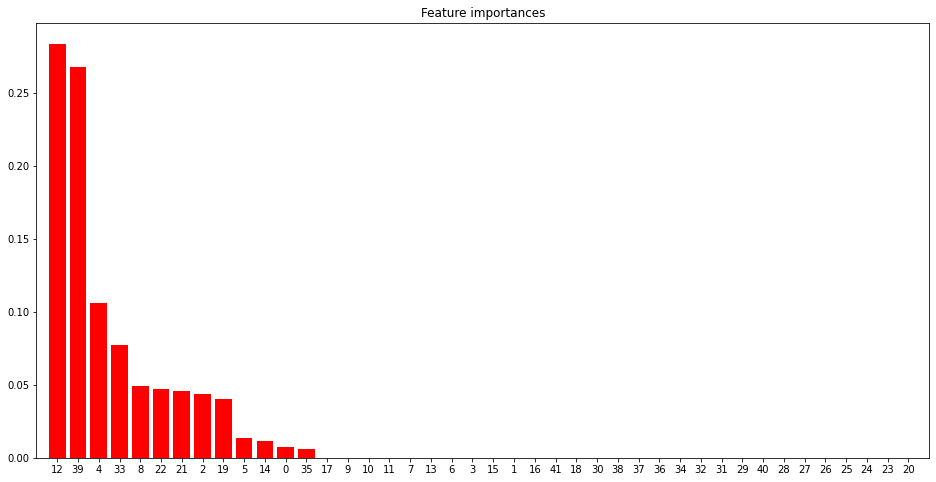

In [45]:
importances = clf.feature_importances_
#std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
indices = np.argsort(importances)[::-1]# Print the feature ranking
print("Feature ranking:")
sel = []
sel_name = []
for f in range(x_train.shape[1]):    
    print("%d. feature %d %s (%f)" % (f+1, indices[f], columns[indices[f]],  importances[indices[f]]))
    sel.append(indices[f])
    sel_name.append(columns[indices[f]])
# Plot the feature importances of the forest
plt.figure(figsize=(16,8))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(x_train.shape[1]), indices)
plt.xlim([-1, x_train.shape[1]])
plt.show()

In [54]:
sel_name

['bid_volume1',
 'offer_price1',
 'total_volume_trade',
 'preclose',
 'offer_price6',
 'bid_price4',
 'offer_price1',
 'bid_volume3',
 'offer_price6',
 'offer_volume9',
 'offer_volume3',
 'bid_volume10',
 'offer_price5',
 'bid_volume4',
 'offer_price9']

In [55]:
#sel_name = sel_name1+sel_name2+sel_name[:5]
x_train = deepcopy(df.loc[:,sel_name])
columns = x_train.columns
x_train = x_train.values
y_train = deepcopy(df.iloc[:,-1]).values
clf = tree.DecisionTreeClassifier(**params)
clf.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=10, min_samples_split=20,
                       random_state=0, splitter='random')

Feature ranking:
1. feature 2 total_volume_trade (0.474469)
2. feature 3 preclose (0.313627)
3. feature 1 offer_price1 (0.090738)
4. feature 5 bid_price4 (0.047210)
5. feature 0 bid_volume1 (0.042158)
6. feature 4 offer_price6 (0.021156)
7. feature 14 offer_price9 (0.007260)
8. feature 10 offer_volume3 (0.003382)
9. feature 13 bid_volume4 (0.000000)
10. feature 12 offer_price5 (0.000000)
11. feature 11 bid_volume10 (0.000000)
12. feature 9 offer_volume9 (0.000000)
13. feature 8 offer_price6 (0.000000)
14. feature 7 bid_volume3 (0.000000)
15. feature 6 offer_price1 (0.000000)


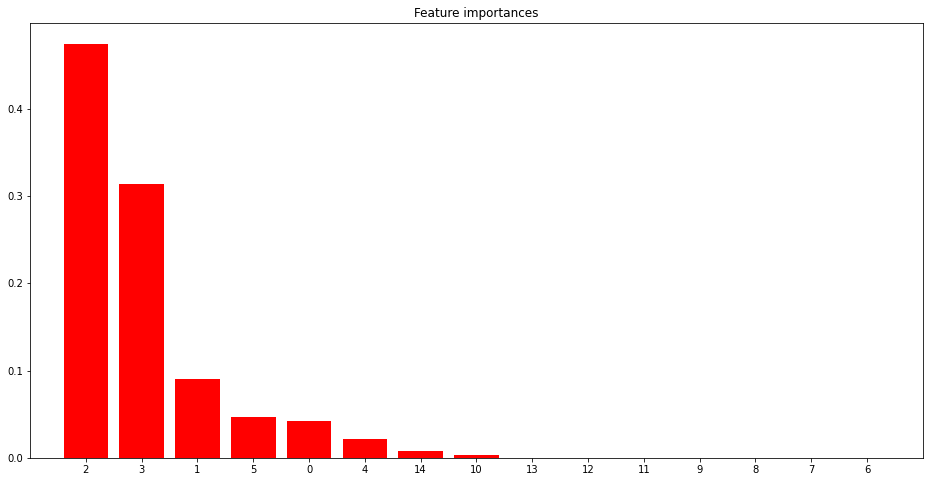

In [56]:
importances = clf.feature_importances_
#std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
indices = np.argsort(importances)[::-1]# Print the feature ranking
print("Feature ranking:")
sel = []
for f in range(x_train.shape[1]):    
    print("%d. feature %d %s (%f)" % (f+1, indices[f], columns[indices[f]],  importances[indices[f]]))
    sel.append(indices[f])
# Plot the feature importances of the forest
plt.figure(figsize=(16,8))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(x_train.shape[1]), indices)
plt.xlim([-1, x_train.shape[1]])
plt.show()

In [57]:
y_predprob = clf.predict_proba(x_train)
y_pred = clf.predict(x_train)
print("accuracy_score Score (Train): %f" % accuracy_score(y_train, y_pred))
print("AUC Score (Train): %f" % roc_auc_score(y_train, y_predprob,multi_class='ovr'))
print(confusion_matrix(y_train, y_pred))

accuracy_score Score (Train): 0.704276
AUC Score (Train): 0.540176
[[   586  40645      7]
 [   435 196288      7]
 [   258  41320     12]]


## opt params

In [58]:
param_opts = {'max_depth':range(4,10,1),
             'min_samples_split':range(2,30,2),
             'min_samples_leaf':range(1,30,2),
             'class_weight': [None, 'balanced', {-1:0.4, 0:0.2, 1:0.4}],
             'random_state':[0,5]
            }

params = {'splitter':'random',
          'max_depth':4,
          'min_samples_split':20,
          'min_samples_leaf':20,
          'class_weight':'balanced',
          'random_state':0
         }
clf = tree.DecisionTreeClassifier(**params)
for key, val in param_opts.items():
    param_opt = {key:val}
    gsearch = GridSearchCV(estimator = clf,
                           param_grid = param_opt,
                           scoring = 'roc_auc_ovr_weighted',
                           verbose = 2,
                           cv=3)
    gsearch.fit(x_train,y_train)
    print(gsearch.cv_results_, gsearch.best_params_, gsearch.best_score_)
    params[key] = gsearch.best_params_[key]
    clf = tree.DecisionTreeClassifier(**params)

param_opt = {'max_depth':[5,10,20,30,100,200]}
gsearch = GridSearchCV(estimator = clf,
                       param_grid = param_opt,
                       scoring = 'roc_auc_ovr_weighted',
                       verbose = 2,
                       cv=3)
gsearch.fit(x_train,y_train)
print(gsearch.cv_results_, gsearch.best_params_, gsearch.best_score_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] max_depth=4 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ...................................... max_depth=4, total=   0.2s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.2s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.2s
[CV] max_depth=5 .....................................................
[CV] ...................................... max_depth=5, total=   0.2s
[CV] max_depth=5 .....................................................
[CV] ...................................... max_depth=5, total=   0.2s
[CV] max_depth=5 .....................................................
[CV] ...................................... max_depth=5, total=   0.2s
[CV] max_depth=6 .....................................................
[CV] ...................................... max_depth=6, total=   0.2s
[CV] max_depth=6 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. min_samples_split=2, total=   0.2s
[CV] min_samples_split=2 .............................................
[CV] .............................. min_samples_split=2, total=   0.2s
[CV] min_samples_split=2 .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .............................. min_samples_split=2, total=   0.2s
[CV] min_samples_split=4 .............................................
[CV] .............................. min_samples_split=4, total=   0.2s
[CV] min_samples_split=4 .............................................
[CV] .............................. min_samples_split=4, total=   0.2s
[CV] min_samples_split=4 .............................................
[CV] .............................. min_samples_split=4, total=   0.2s
[CV] min_samples_split=6 .............................................
[CV] .............................. min_samples_split=6, total=   0.2s
[CV] min_samples_split=6 .............................................
[CV] .............................. min_samples_split=6, total=   0.3s
[CV] min_samples_split=6 .............................................
[CV] .............................. min_samples_split=6, total=   0.2s
[CV] min_samples_split=8 .............................................
[CV] .

[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:    8.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'mean_fit_time': array([0.1549801 , 0.15600673, 0.17739256, 0.1489807 , 0.14318935,
       0.14548842, 0.14881341, 0.15142965, 0.15071591, 0.15347759,
       0.14894867, 0.14491796, 0.14912796, 0.15660167]), 'std_fit_time': array([0.00947015, 0.00578585, 0.02010631, 0.00902055, 0.00912313,
       0.00401138, 0.01046873, 0.00171385, 0.00488905, 0.00653741,
       0.01308402, 0.00880032, 0.00814351, 0.00534087]), 'mean_score_time': array([0.047539  , 0.04609656, 0.04615466, 0.04288157, 0.04243167,
       0.04275195, 0.04266961, 0.04439068, 0.04342262, 0.04539792,
       0.04204965, 0.04210941, 0.04347769, 0.04573329]), 'std_score_time': array([0.00043563, 0.00273079, 0.00491507, 0.00231285, 0.00184759,
       0.00250602, 0.002018  , 0.00215502, 0.00187489, 0.00127873,
       0.00319561, 0.00164231, 0.00318076, 0.0037604 ]), 'param_min_samples_split': masked_array(data=[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28],
             mask=[False, False, False, False, False, False, False

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ............................... min_samples_leaf=1, total=   0.2s
[CV] min_samples_leaf=1 ..............................................
[CV] ............................... min_samples_leaf=1, total=   0.2s
[CV] min_samples_leaf=3 ..............................................
[CV] ............................... min_samples_leaf=3, total=   0.2s
[CV] min_samples_leaf=3 ..............................................
[CV] ............................... min_samples_leaf=3, total=   0.2s
[CV] min_samples_leaf=3 ..............................................
[CV] ............................... min_samples_leaf=3, total=   0.2s
[CV] min_samples_leaf=5 ..............................................
[CV] ............................... min_samples_leaf=5, total=   0.2s
[CV] min_samples_leaf=5 ..............................................
[CV] ............................... min_samples_leaf=5, total=   0.2s
[CV] min_samples_leaf=5 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    8.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................ class_weight=None, total=   0.2s
[CV] class_weight=None ...............................................
[CV] ................................ class_weight=None, total=   0.2s
[CV] class_weight=None ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ................................ class_weight=None, total=   0.2s
[CV] class_weight=balanced ...........................................
[CV] ............................ class_weight=balanced, total=   0.2s
[CV] class_weight=balanced ...........................................
[CV] ............................ class_weight=balanced, total=   0.2s
[CV] class_weight=balanced ...........................................
[CV] ............................ class_weight=balanced, total=   0.2s
[CV] class_weight={-1: 0.4, 0: 0.2, 1: 0.4} ..........................
[CV] ........... class_weight={-1: 0.4, 0: 0.2, 1: 0.4}, total=   0.2s
[CV] class_weight={-1: 0.4, 0: 0.2, 1: 0.4} ..........................
[CV] ........... class_weight={-1: 0.4, 0: 0.2, 1: 0.4}, total=   0.2s
[CV] class_weight={-1: 0.4, 0: 0.2, 1: 0.4} ..........................
[CV] ........... class_weight={-1: 0.4, 0: 0.2, 1: 0.4}, total=   0.2s
{'mean_fit_time': array([0.117143  , 0.14650305, 0.14660764]), 'std_fit_time'

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................... random_state=0, total=   0.2s
[CV] random_state=0 ..................................................
[CV] ................................... random_state=0, total=   0.2s
[CV] random_state=0 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ................................... random_state=0, total=   0.2s
[CV] random_state=5 ..................................................
[CV] ................................... random_state=5, total=   0.2s
[CV] random_state=5 ..................................................
[CV] ................................... random_state=5, total=   0.2s
[CV] random_state=5 ..................................................
[CV] ................................... random_state=5, total=   0.2s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'mean_fit_time': array([0.14177291, 0.13486632]), 'std_fit_time': array([0.00229605, 0.00128895]), 'mean_score_time': array([0.04270498, 0.04149493]), 'std_score_time': array([0.00322842, 0.00061989]), 'param_random_state': masked_array(data=[0, 5],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'params': [{'random_state': 0}, {'random_state': 5}], 'split0_test_score': array([0.46890548, 0.44275191]), 'split1_test_score': array([0.36832446, 0.37233792]), 'split2_test_score': array([0.46211668, 0.44899927]), 'mean_test_score': array([0.43311554, 0.42136303]), 'std_test_score': array([0.04589797, 0.03475969]), 'rank_test_score': array([1, 2], dtype=int32)} {'random_state': 0} 0.433115543497305
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] max_depth=5 .....................................................
[CV] ...................................... max_depth=5, total=   0.2s
[CV] max_depth=5 ..........................................

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ...................................... max_depth=5, total=   0.2s
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total=   0.3s
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total=   0.2s
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total=   0.3s
[CV] max_depth=20 ....................................................
[CV] ..................................... max_depth=20, total=   0.4s
[CV] max_depth=20 ....................................................
[CV] ..................................... max_depth=20, total=   0.3s
[CV] max_depth=20 ....................................................
[CV] ..................................... max_depth=20, total=   0.4s
[CV] max_depth=30 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    6.0s finished


In [85]:
class MYModel(object):
    def __init__(self, model, traindate, testdate):
        self.model = model
        self.traindate = traindate
        self.testdate = testdate
        
    @staticmethod
    def select(startdate, enddate, pathsplit="HQ/tick_159919/splitdata.h5"):
        with pd.HDFStore(pathsplit, 'r') as split:
            keys = list(split.keys())
            keys = [i for i in keys if i>=pathsplit[2:14]+"_"+str(startdate) and i<=pathsplit[2:14] + "_" + str(enddate)]
            df = pd.DataFrame()
            for i in range(len(keys)):
                df = df.append(split[keys[i]])
        return df

    def fit(self):
        df = self.select(self.traindate[0], self.traindate[1])
        x_train = deepcopy(df.iloc[:,:-2])
        x_train = x_train.values
        y_train = deepcopy(df.iloc[:,-1]).values
        robustscaler = RobustScaler().fit(x_train)
        x_train = robustscaler.transform(x_train)
        standardscaler = StandardScaler().fit(x_train)
        x_train = standardscaler.transform(x_train)
        minmaxscaler = MinMaxScaler().fit(x_train)
        x_train = minmaxscaler.transform(x_train)
        pca = SparsePCA(n_components=7, random_state=15).fit(x_train)
        x_train = pca.transform(x_train)
        idx = [i for i in range(x_train.shape[0])]
        np.random.shuffle(idx)
        x_train = x_train[idx]
        y_train = y_train[idx]
        self.model.fit(x_train, y_train)
    
    def predict(self):
        df = self.select(self.testdate[0], self.testdate[1])
        x_test = deepcopy(df.iloc[:,:-2])
        x_test = x_test.values
        y_test = deepcopy(df.iloc[:,-1]).values
        robustscaler = RobustScaler().fit(x_test)
        x_test = robustscaler.transform(x_test)
        standardscaler = StandardScaler().fit(x_test)
        x_test = standardscaler.transform(x_test)
        minmaxscaler = MinMaxScaler().fit(x_test)
        x_test = minmaxscaler.transform(x_test)
        pca = SparsePCA(n_components=7, random_state=15).fit(x_test)
        x_test = pca.transform(x_test)
        y_pred = self.model.predict(x_test)
        self.mat = pd.DataFrame(index = df.index)
        self.mat['date'] = self.mat.index.date
        self.mat['y_true'] = y_test
        self.mat['y_pred'] = y_pred
        self.mat['mid'] = (df['offer_price1'].values + df['bid_price1'].values)/2
        self.mat['date'] = self.mat.index.date
    
    def plot(self):
        print(np.sum(self.mat.y_pred == -1), np.sum(self.mat.y_pred == 0), np.sum(self.mat.y_pred == 1))
        result = pd.DataFrame()
        result['obs'] = self.mat.groupby(['date']).size()
        result['mid'] = self.mat.groupby(['date']).apply(lambda di:np.mean(di['mid']))
        result['std'] = self.mat.groupby(['date']).apply(lambda di:np.std(di['mid']))
        result['ratio'] = self.mat.groupby(['date']).apply(lambda di:np.sum(di['y_true']==di['y_pred'])/di.shape[0])
        result['mse'] = self.mat.groupby(['date']).apply(lambda di:np.sum(np.square(di['y_true']-di['y_pred']))/di.shape[0])
        result.ratio.plot(figsize=(16,8), grid=False, kind="bar", xticks=())

In [86]:
params = {'splitter':'random',
          'max_depth':4,
          'min_samples_split':20,
          'min_samples_leaf':20,
          'class_weight':'balanced',
          'random_state':0
         }
clf = tree.DecisionTreeClassifier(**params)
model = MYModel(clf,[20170101,20170601], [20170602,20171231])
model.fit()
mat = model.predict()

In [87]:
mat['date'] = mat.index.date
print(np.sum(mat.y_pred == -1), np.sum(mat.y_pred == 0), np.sum(mat.y_pred == 1))
result = pd.DataFrame()
result['obs'] = mat.groupby(['date']).size()
result['mid'] = mat.groupby(['date']).apply(lambda di:np.mean(di['mid']))
result['std'] = mat.groupby(['date']).apply(lambda di:np.std(di['mid']))
result['ratio'] = mat.groupby(['date']).apply(lambda di:np.sum(di['y_true']==di['y_pred'])/di.shape[0])
result['mse'] = mat.groupby(['date']).apply(lambda di:np.sum(np.square(di['y_true']-di['y_pred']))/di.shape[0])

95661 100400 268998


<AxesSubplot:xlabel='date'>

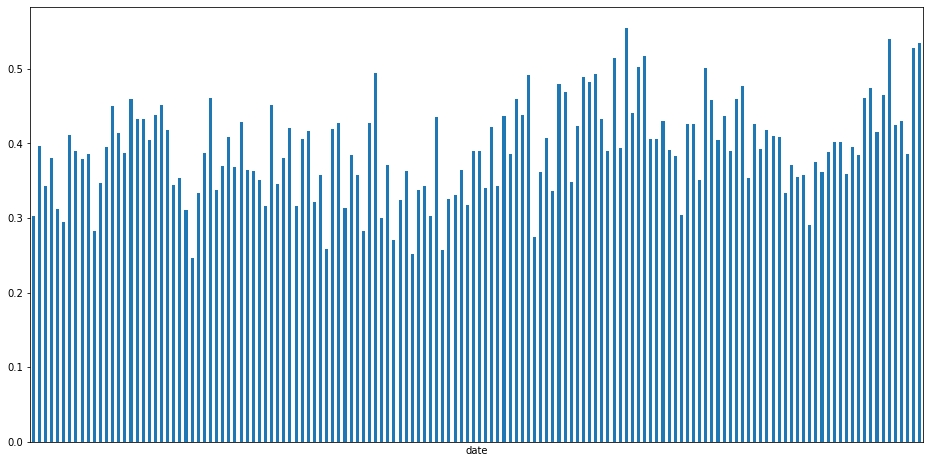

In [71]:
result.ratio.plot(figsize=(16,8), grid=False, kind="bar", xticks=())

<AxesSubplot:xlabel='date'>

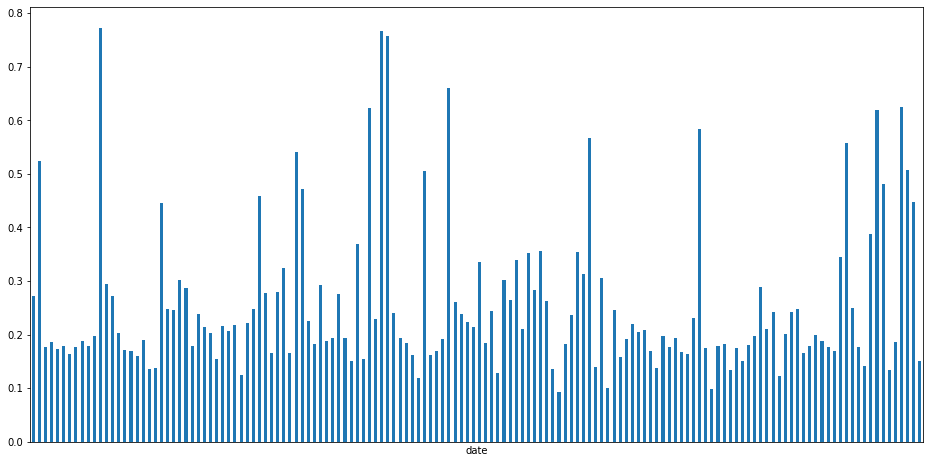

In [88]:
result.ratio.plot(figsize=(16,8), grid=False, kind="bar", xticks=())

## random forest

In [200]:
from sklearn.ensemble import RandomForestClassifier
import random
params = {'n_estimators': 262,
          'oob_score': True,
          'max_features': 'auto',
          'max_depth': 3,
          'min_samples_split': 128,
          'min_samples_leaf': 78,
          'min_weight_fraction_leaf': 0,
          'max_leaf_nodes': None, # over fitting
          'min_impurity_decrease': 0,
          'n_jobs': None,
          'class_weight':None,
          'random_state': 15
          }
clf = RandomForestClassifier(**params)
model = MYModel(clf,[20180101,20180631], [20180701,20181230])
model.fit()
model.predict()

721 592902 161


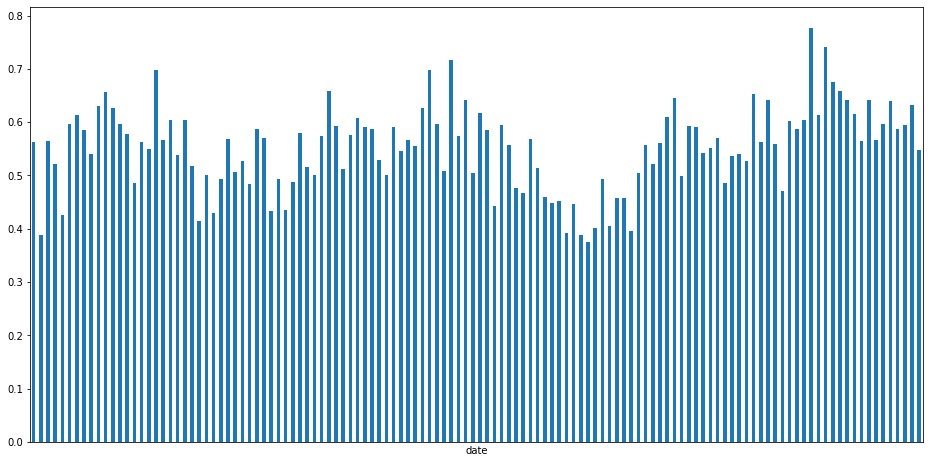

In [201]:
model.plot()

190375 8131 362054


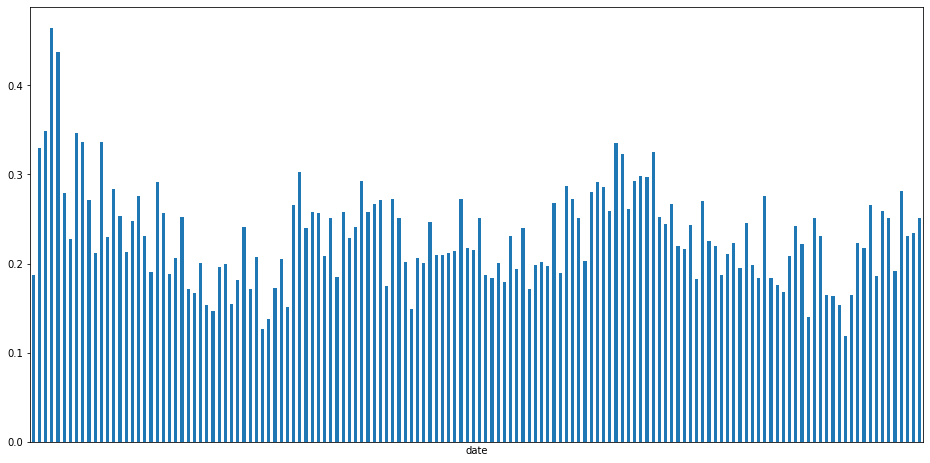

In [114]:
model.plot()

In [141]:
from sklearn.metrics import precision_score, recall_score, f1_score
def recall(mat):
    return recall_score(mat.y_true, mat.y_pred, average='weighted')
def precision(mat):
    return precision_score(mat.y_true, mat.y_pred, average='weighted')
def f1(mat):
    return f1_score(mat.y_true, mat.y_pred, average='weighted')

In [202]:
mat = model.mat
result = pd.DataFrame()
result['obs'] = mat.groupby(['date']).size()
result['mid'] = mat.groupby(['date']).apply(lambda di:np.mean(di['mid']))
result['std'] = mat.groupby(['date']).apply(lambda di:np.std(di['mid']))
result['ratio'] = mat.groupby(['date']).apply(lambda di:np.sum(di['y_true']==di['y_pred'])/di.shape[0])
result['mse'] = mat.groupby(['date']).apply(lambda di:np.sum(np.square(di['y_true']-di['y_pred']))/di.shape[0])
result['recall'] = mat.groupby(['date']).apply(recall)
result['precision'] = mat.groupby(['date']).apply(precision)
result['f1'] = mat.groupby(['date']).apply(f1)
result0 = deepcopy(result)

/Users/jwu/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:xlabel='date'>

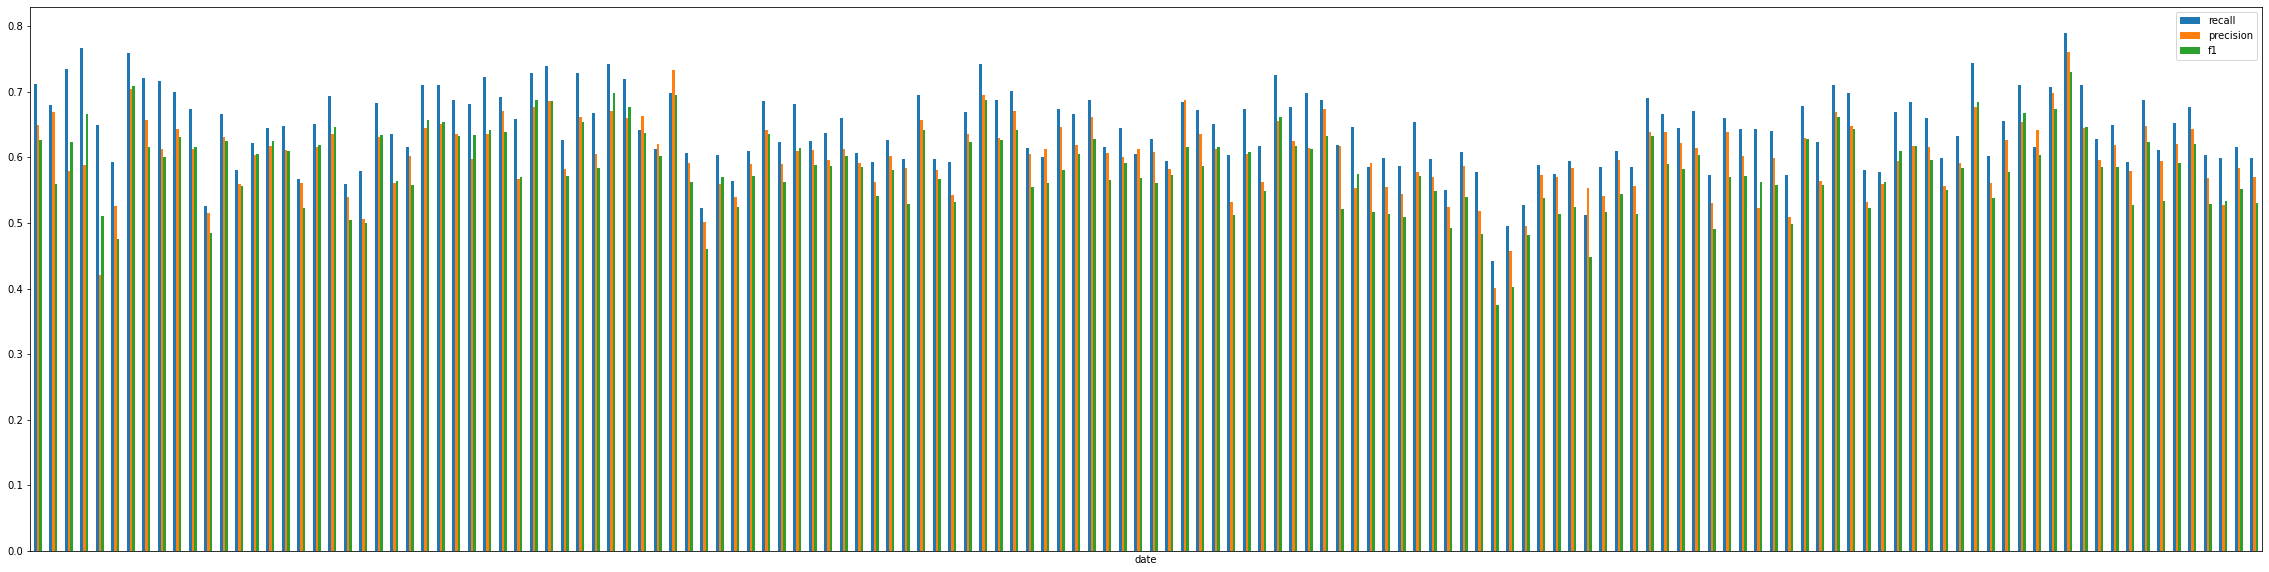

In [151]:
result.loc[:,['recall','precision','f1']].plot(figsize=(40,10), grid=False, kind="bar", xticks=())

## lightgbm

In [ ]:
import lightgbm as lgb
params = {'objective': 'multiclass',
          'is_unbalance': True,
          'n_estimators': 262,
          'max_depth': 3,
          'num_leaves': 128,
          'learning_rate': 0.04,
          'min_child_samples': 78,
          'min_child_weight': 0.001,
          'feature_fraction': 0.7,
          'bagging_fraction': 0.6,
          'bagging_freq': 15,
          'reg_alpha': 0.001,
          'reg_lambda': 8,
          'random_state': 15
          }
clf = lgb.LGBMClassifier(**params)
clf.fit(x_train, y_train)
model = MYModel(clf,[20180101,20180630], [20180701,20181230])
model.fit()
model.predict()

[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


In [ ]:
model.plot()

104392 435749 126663


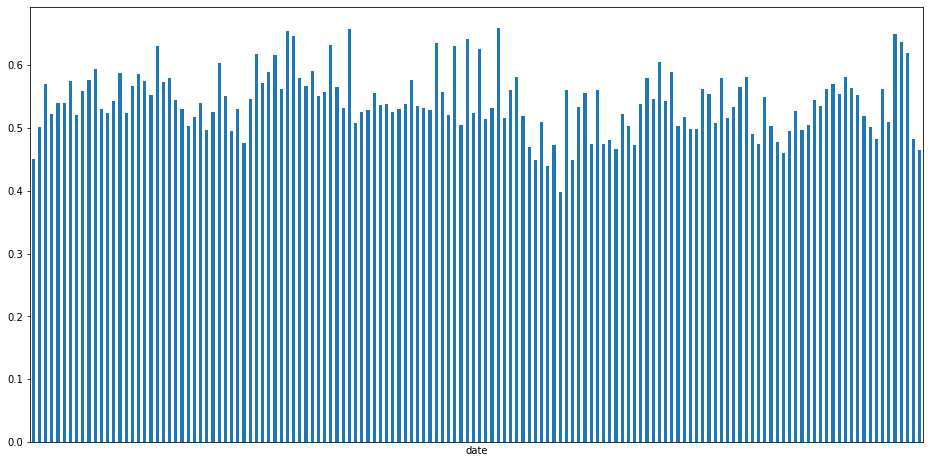

In [178]:
model.plot()

In [204]:
mat = model.mat
result = pd.DataFrame()
result['obs'] = mat.groupby(['date']).size()
result['mid'] = mat.groupby(['date']).apply(lambda di:np.mean(di['mid']))
result['std'] = mat.groupby(['date']).apply(lambda di:np.std(di['mid']))
result['ratio'] = mat.groupby(['date']).apply(lambda di:np.sum(di['y_true']==di['y_pred'])/di.shape[0])
result['mse'] = mat.groupby(['date']).apply(lambda di:np.sum(np.square(di['y_true']-di['y_pred']))/di.shape[0])

In [205]:
result['recall'] = mat.groupby(['date']).apply(recall)
result['precision'] = mat.groupby(['date']).apply(precision)
result['f1'] = mat.groupby(['date']).apply(f1)
result1 = deepcopy(result)

In [181]:
result = pd.concat([result1,result2,result3])

In [182]:
result

,obs,mid,std,ratio,mse,recall,precision,f1
date,,,,,,,,
2017-06-01,3082,3.756208,0.003588,0.723232,0.349773,0.723232,0.714951,0.718890
2017-06-02,3159,3.749959,0.007275,0.663501,0.479899,0.663501,0.723868,0.687726
2017-06-05,3600,3.737828,0.005260,0.602500,0.512500,0.602500,0.632515,0.614997
2017-06-06,2953,3.742847,0.004895,0.593295,0.537758,0.593295,0.597552,0.593193
2017-06-07,3709,3.792491,0.008933,0.570504,0.570235,0.570504,0.607750,0.586415
...,...,...,...,...,...,...,...,...
2019-12-24,4671,4.039779,0.007382,0.649326,0.355812,0.649326,0.636991,0.522747
2019-12-25,4660,4.049513,0.005517,0.637124,0.366738,0.637124,0.603474,0.506719
2019-12-26,4692,4.067218,0.005902,0.619991,0.400469,0.619991,0.575753,0.497198


<AxesSubplot:xlabel='date'>

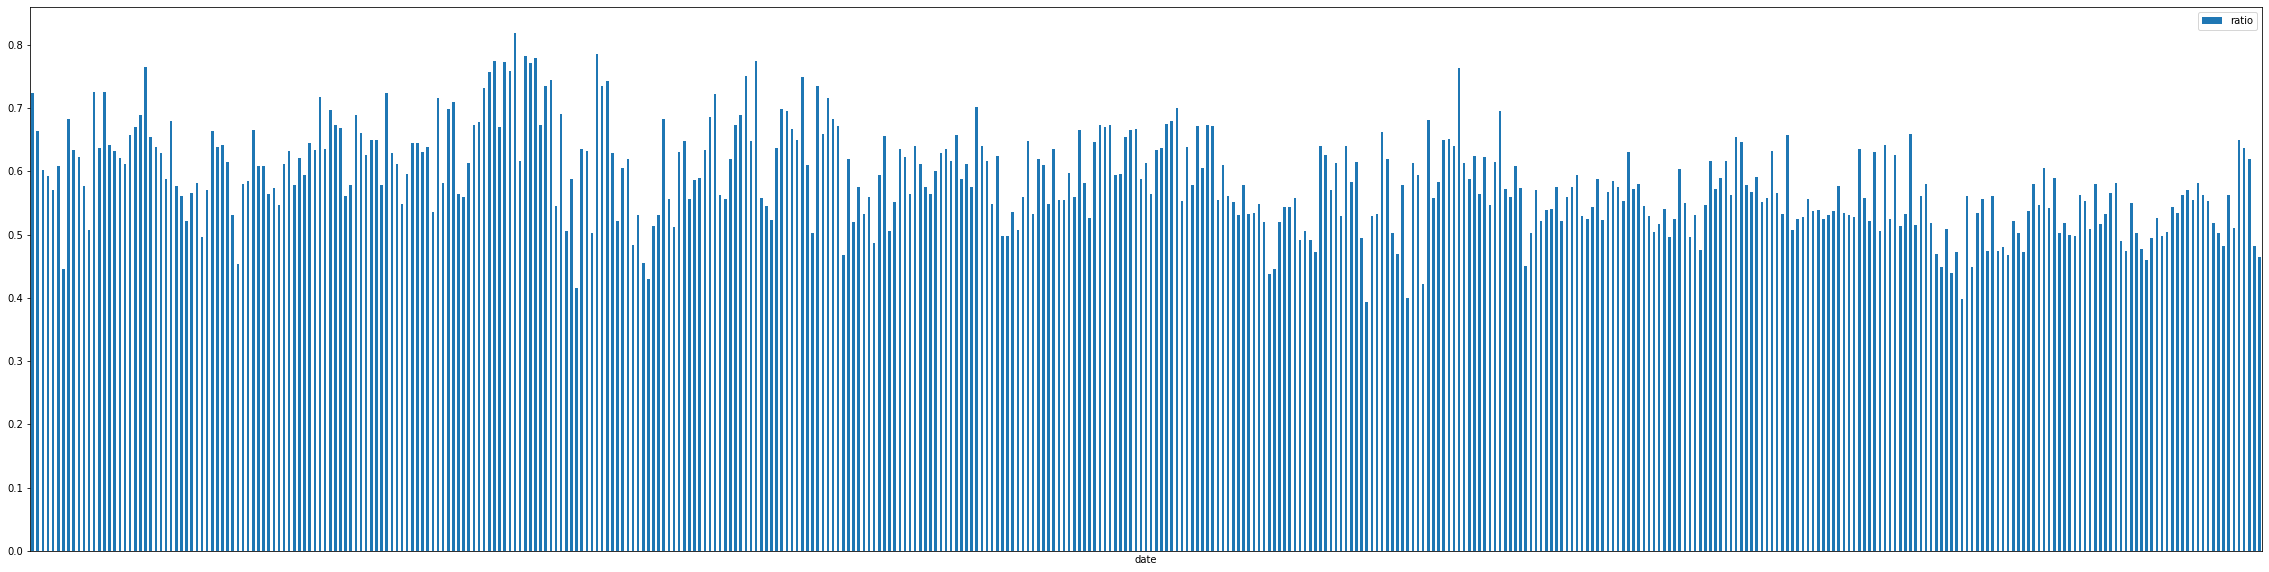

In [184]:
result.loc[:,['ratio']].plot(figsize=(40,10), grid=False, kind="bar", xticks=())

<AxesSubplot:xlabel='date'>

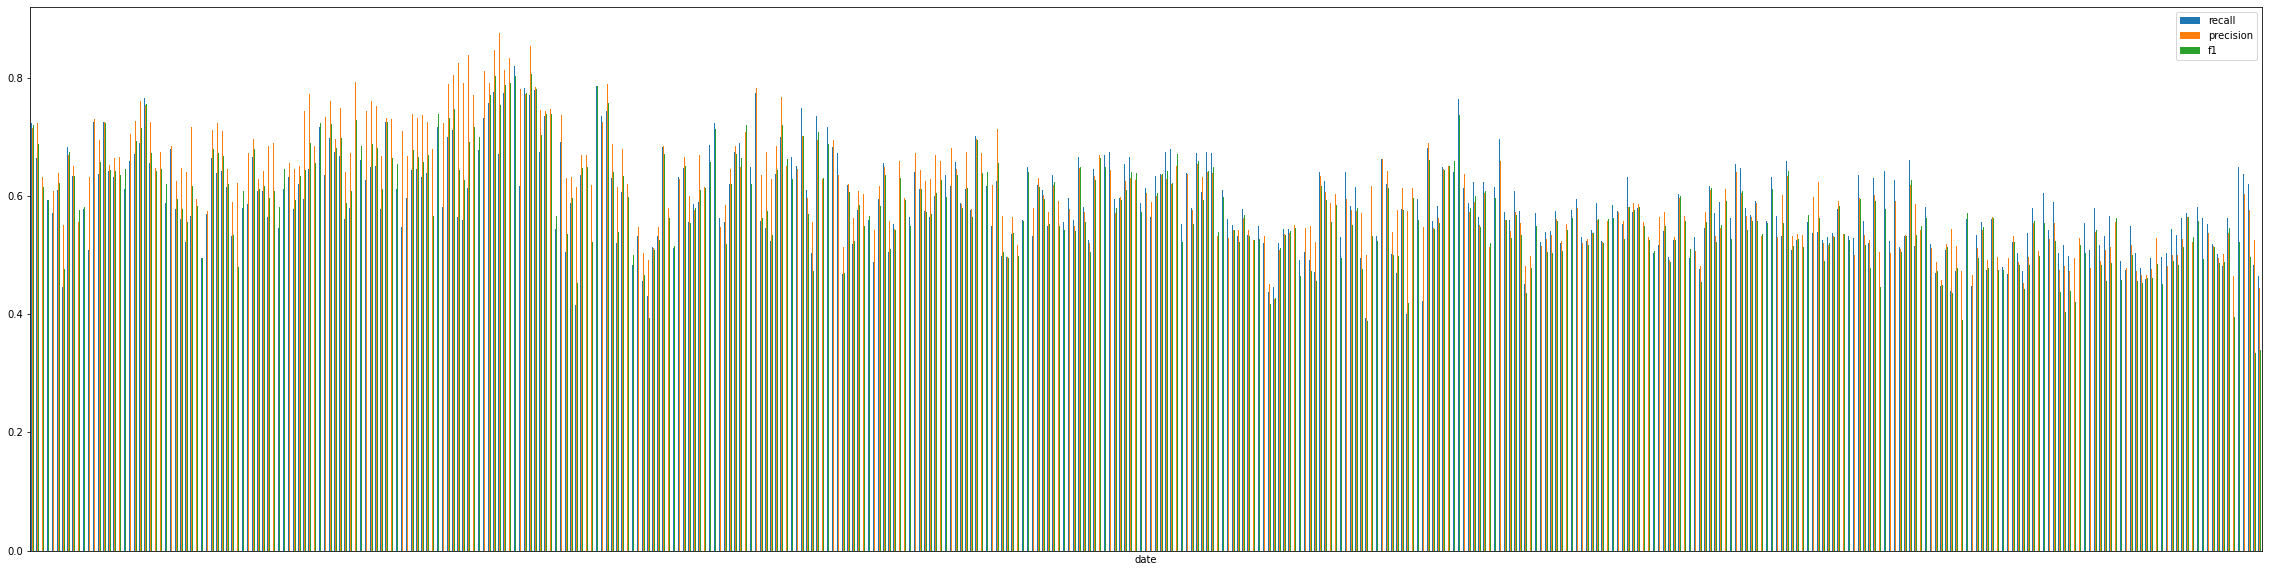

In [183]:
result.loc[:,['recall','precision','f1']].plot(figsize=(40,10), grid=False, kind="bar", xticks=())

In [189]:
import lightgbm as lgb
params = {'objective': 'multiclass',
          'is_unbalance': True,
          'n_estimators': 262,
          'max_depth': 3,
          'num_leaves': 128,
          'learning_rate': 0.04,
          'min_child_samples': 78,
          'min_child_weight': 0.001,
          'feature_fraction': 0.7,
          'bagging_fraction': 0.6,
          'bagging_freq': 15,
          'reg_alpha': 0.001,
          'reg_lambda': 8,
          'random_state': 15
          }
clf = lgb.LGBMClassifier(**params)
clf.fit(x_train, y_train)
model = MYModel(clf,[20180101,20180531], [20180601,20181230])
model.fit()
model.predict()

[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


In [190]:
mat = model.mat
result = pd.DataFrame()
result['obs'] = mat.groupby(['date']).size()
result['mid'] = mat.groupby(['date']).apply(lambda di:np.mean(di['mid']))
result['std'] = mat.groupby(['date']).apply(lambda di:np.std(di['mid']))
result['ratio'] = mat.groupby(['date']).apply(lambda di:np.sum(di['y_true']==di['y_pred'])/di.shape[0])
result['mse'] = mat.groupby(['date']).apply(lambda di:np.sum(np.square(di['y_true']-di['y_pred']))/di.shape[0])
result['recall'] = mat.groupby(['date']).apply(recall)
result['precision'] = mat.groupby(['date']).apply(precision)
result['f1'] = mat.groupby(['date']).apply(f1)
result2 = deepcopy(result)

<AxesSubplot:xlabel='date'>

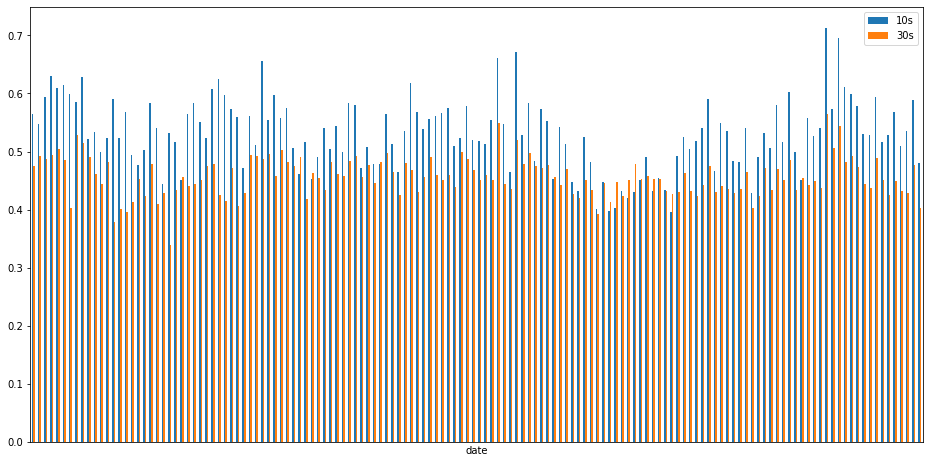

In [193]:
df = pd.DataFrame(index = result1.index)
df['10s'] = result2.f1
df['30s'] = result1.f1
df.plot(figsize=(16,8), grid=False, kind="bar", xticks=())

## xgboost

In [216]:
class MYModel(object):
    def __init__(self, model, traindate, testdate):
        self.model = model
        self.traindate = traindate
        self.testdate = testdate
        
    @staticmethod
    def select(startdate, enddate, pathsplit="HQ/tick_510300/splitdata10s.h5"):
        with pd.HDFStore(pathsplit, 'r') as split:
            keys = list(split.keys())
            keys = [i for i in keys if i>=pathsplit[2:14]+"_"+str(startdate) and i<=pathsplit[2:14] + "_" + str(enddate)]
            df = pd.DataFrame()
            for i in range(len(keys)):
                df = df.append(split[keys[i]])
        return df

    @staticmethod
    def resample(x_train, y_train):
        a, b, c = (np.sum(y_train==-1),np.sum(y_train==0),np.sum(y_train==1))
        keeps = a+c
        idx = np.where(y_train==0)[0]
        idx = random.sample(list(idx), keeps)
        idx = idx + list(np.where(y_train==-1)[0]) + list(np.where(y_train==1)[0])
        x_train = x_train[idx]
        y_train = y_train[idx]
        return x_train, y_train

    def fit(self):
        df = self.select(self.traindate[0], self.traindate[1])
        x_train = deepcopy(df.iloc[:,:-2])
        x_train = x_train.values
        y_train = deepcopy(df.iloc[:,-1]).values
        x_train, y_train = self.resample(x_train, y_train)
        robustscaler = RobustScaler().fit(x_train)
        x_train = robustscaler.transform(x_train)
        standardscaler = StandardScaler().fit(x_train)
        x_train = standardscaler.transform(x_train)
        minmaxscaler = MinMaxScaler().fit(x_train)
        x_train = minmaxscaler.transform(x_train)
        pca = SparsePCA(n_components=7, random_state=15).fit(x_train)
        x_train = pca.transform(x_train)
        idx = [i for i in range(x_train.shape[0])]
        np.random.shuffle(idx)
        x_train = x_train[idx]
        y_train = y_train[idx]
        self.model.fit(x_train, y_train)
        self.x_train = x_train
        self.y_train = y_train
    
    def predict(self):
        df = self.select(self.testdate[0], self.testdate[1])
        x_test = deepcopy(df.iloc[:,:-2])
        x_test = x_test.values
        y_test = deepcopy(df.iloc[:,-1]).values
        robustscaler = RobustScaler().fit(x_test)
        x_test = robustscaler.transform(x_test)
        standardscaler = StandardScaler().fit(x_test)
        x_test = standardscaler.transform(x_test)
        minmaxscaler = MinMaxScaler().fit(x_test)
        x_test = minmaxscaler.transform(x_test)
        pca = SparsePCA(n_components=7, random_state=15).fit(x_test)
        x_test = pca.transform(x_test)
        y_pred = self.model.predict(x_test)
        self.mat = pd.DataFrame(index = df.index)
        self.mat['date'] = self.mat.index.date
        self.mat['y_true'] = y_test
        self.mat['y_pred'] = y_pred
        self.mat['mid'] = (df['offer_price1'].values + df['bid_price1'].values)/2
        self.mat['date'] = self.mat.index.date
        self.x_test = x_test
        self.y_test = y_test
    
    def plot(self):
        print(np.sum(self.mat.y_pred == -1), np.sum(self.mat.y_pred == 0), np.sum(self.mat.y_pred == 1))
        result = pd.DataFrame()
        result['obs'] = self.mat.groupby(['date']).size()
        result['mid'] = self.mat.groupby(['date']).apply(lambda di:np.mean(di['mid']))
        result['std'] = self.mat.groupby(['date']).apply(lambda di:np.std(di['mid']))
        result['ratio'] = self.mat.groupby(['date']).apply(lambda di:np.sum(di['y_true']==di['y_pred'])/di.shape[0])
        result['mse'] = self.mat.groupby(['date']).apply(lambda di:np.sum(np.square(di['y_true']-di['y_pred']))/di.shape[0])
        result.ratio.plot(figsize=(16,8), grid=False, kind="bar", xticks=())

In [197]:
import xgboost as xgb
params = {'n_estimators': 262,
         'max_depth': 3,
         'learning_rate': 0.042,
         'objective': 'multi:softmax',
         'min_child_weight': 78,
         'n_jobs': 1,
         'random_state': 15}
clf = xgb.XGBClassifier(**params)
model = MYModel(clf,[20180101,20180630], [20180701,20181230])
model.fit()
model.predict()

122848 368814 102122


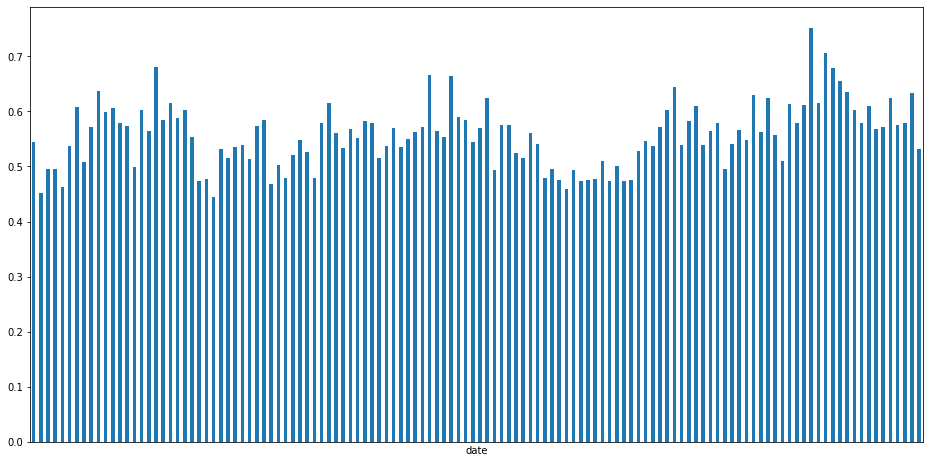

In [198]:
model.plot()

In [199]:
mat = model.mat
result = pd.DataFrame()
result['obs'] = mat.groupby(['date']).size()
result['mid'] = mat.groupby(['date']).apply(lambda di:np.mean(di['mid']))
result['std'] = mat.groupby(['date']).apply(lambda di:np.std(di['mid']))
result['ratio'] = mat.groupby(['date']).apply(lambda di:np.sum(di['y_true']==di['y_pred'])/di.shape[0])
result['mse'] = mat.groupby(['date']).apply(lambda di:np.sum(np.square(di['y_true']-di['y_pred']))/di.shape[0])
result['recall'] = mat.groupby(['date']).apply(recall)
result['precision'] = mat.groupby(['date']).apply(precision)
result['f1'] = mat.groupby(['date']).apply(f1)
result2 = deepcopy(result)

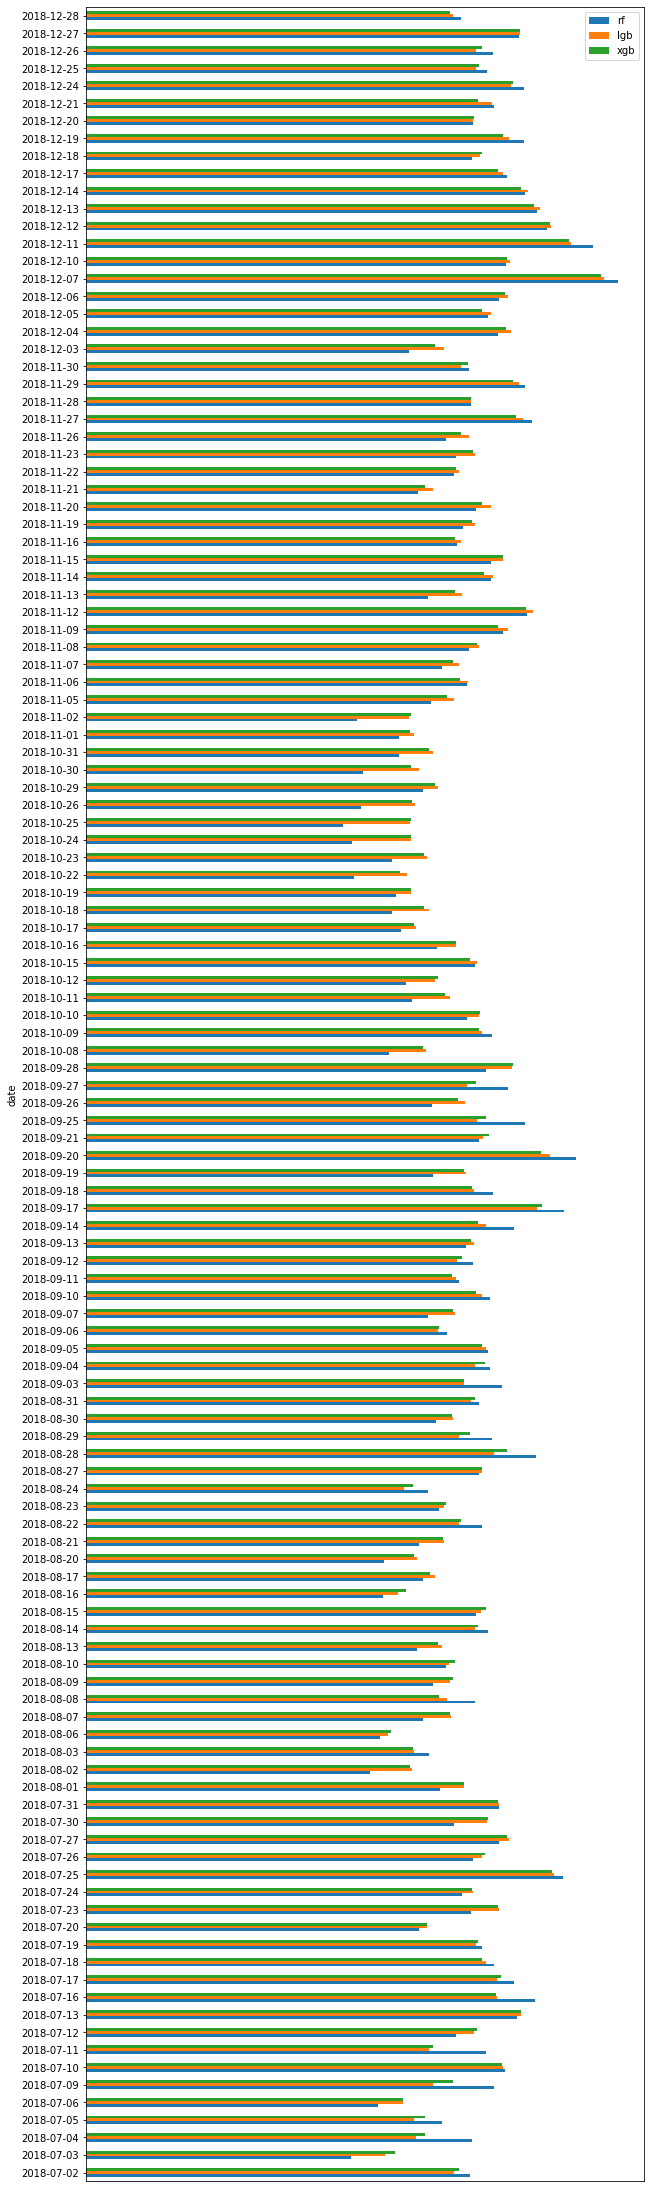

In [214]:
df = pd.DataFrame(index = result0.index)
df['rf'] = result0.ratio
df['lgb'] = result1.ratio
df['xgb'] = result2.ratio
df.plot(figsize=(10,40), grid=False, kind="barh", xticks=())
plt.savefig('picture/comp.png',bbox_inches='tight')

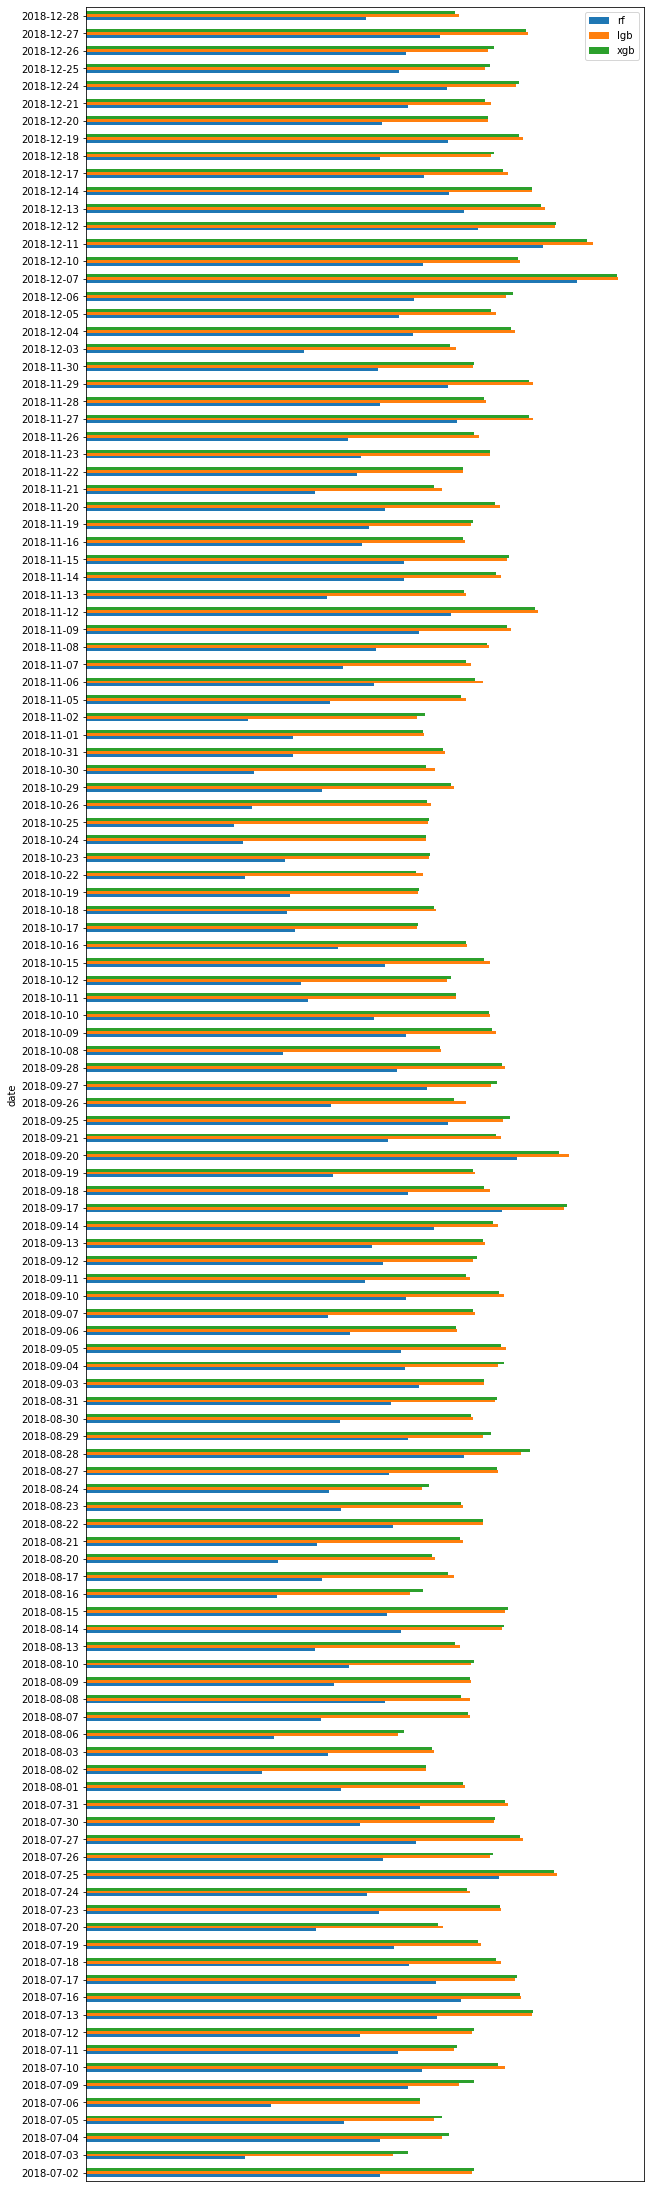

In [215]:
df = pd.DataFrame(index = result0.index)
df['rf'] = result0.f1
df['lgb'] = result1.f1
df['xgb'] = result2.f1
df.plot(figsize=(10,40), grid=False, kind="barh", xticks=())
plt.savefig('picture/comp1.png',bbox_inches='tight')